# Аналитика металлургического комбината "Стальная птица" 🏭

**Описание проекта:** Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Нам необходимо предсказывать температуру сплавов.

**Цель проекта:** Построить модель, которая будет предсказывать температуру сплавов.

**Ход исследования:** 

- Загрузка данных, первичный осмотр
- Исследовательский анализ данных и предобработка отдельных датафреймов. Оценка необходимости признаков для обучения моделей
- Объединение признаков в датафрейм
- Исследовательский анализ данных объединенного датафрейма. Корреляционный анализ
- Подготовка данных и обучение моделей
- Выбор лучшей модели и проверка ее качества на тестовых данных
- Общий вывод и рекомендации заказчику


**Содержание**<a id='toc0_'></a> 

1. [Подготовка данных](#toc1_)                                  
  1.1 [Установка библиотек и конфигурации](#toc1_1_)    
  1.2 [Функции, используемые в проекте](#toc1_2_) 
  
2. [Предобработка данных и исследовательский анализ данных отдельных датафреймов(EDA)](#toc2_)         
  2.1 [Датафрейм data_arc_new.csv](#toc2_1_)                                                      
  2.2 [Датафрейм data_bulk_new.csv](#toc2_2_)                                                          
  2.3 [Датафрейм data_bulk_time_new.csv](#toc2_3_)                                                             
  2.4 [Датафрейм data_gas_new.csv](#toc2_4_)                                                     
  2.5 [Датафрейм data_temp_new.csv](#toc2_5_)                                            
  2.6 [Датафрейм data_wire_new.csv](#toc2_6_)                                   
  2.7 [Датафрейм data_wire_time_new.csv](#toc2_7_)                                        
                 
3. [Объединение данных](#toc3_) 

4. [Исследовательский анализ и предобработка данных объединённого датафрейма](#toc4_)                                                                    
  4.1 [Корреляционный анализ](#toc4_1_)
   
5. [Построение и обучение моделей](#toc5_)                                                                                                       
  5.1 [Подготовка данных](#toc5_1_)                 
  5.2 [Построение пайплайна для моделей](#toc5_2_)                                                                      
  5.3 [Выбор лучшей модели](#toc5_3_)                                           
  5.4 [Анализ остатков](#toc5_4_)                                                                            

6. [Анализ важности признаков](#toc6_)

7. [Общий вывод](#toc7_)



## <a id='toc1_'></a> 1. Подготовка данных[&#8593;](#toc0_)

### <a id='toc1_1_'></a> 1.1 Установка библиотек  и конфигурации [&#8593;](#toc0_)

In [1]:
from IPython.display import clear_output

In [2]:
from platform import python_version
version = python_version()

if version.startswith('3.9'):  
    pass
    %pip install --force-reinstall -v "numpy==1.22.4" -q
else: 
    pass
    %pip install --upgrade numpy -q   

%pip install --force-reinstall -v "matplotlib==3.8.0" -q

%pip install --upgrade phik -q
%pip install --upgrade prettytable -q
%pip install --upgrade termcolor -q
%pip install --upgrade seaborn -q
%pip install --upgrade pandas -q
%pip install --upgrade statsmodels -q
%pip install --upgrade scikit-learn -q
%pip install --upgrade shap -q
%pip install --upgrade imbalanced-learn -q
%pip install --upgrade optuna -q

clear_output()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap 

from os.path import exists

# preprocessing
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split)
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder)
from sklearn.impute import (
    SimpleImputer)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import  DummyRegressor
# metrics
from sklearn.metrics import (
    mean_absolute_error,
    ConfusionMatrixDisplay)

# additional tools
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance
from phik import phik_matrix 
from prettytable import PrettyTable
from termcolor import colored
from statsmodels.tools.tools import add_constant

In [4]:
RANDOM_STATE = 250225
TEST_SIZE = 0.25

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)

### <a id='toc1_2_'></a> 1.2 Функции, используемые в проекте [&#8593;](#toc0_)

In [5]:
def get_dataframe(paths: list[str]) -> pd.DataFrame:
    for _path in paths:
        if not exists(_path) and not _path.startswith('http'):
            continue
        
        try:
            df = pd.read_csv(_path)
        except:
            continue
        
        if df is None:
            continue
        
        return df
    
    raise FileNotFoundError('No paths are valid and/or for correct csv file.')

In [6]:
def print_nans_table(data: pd.DataFrame) -> None:
    table = PrettyTable()
    table.field_names = ['Признаки', 'Пропущенное количество значений']
    
    missing_info = data.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'blue' if count == 0 else 'red'
        s = f'{count} ({count / len(data):.1%})'
        table.add_row([col, colored(s, color)])
    
    print(table)

In [7]:
def the_basic_plots(df: pd.DataFrame,
                    column: str,
                    column_description: str,
                    bins: int = 25
                    ) -> None:
    
    _, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 6))

    sns.boxplot(data=df, x=column, ax=ax1)
    ax1.set_xlabel(column_description)
    ax1.grid()

    sns.histplot(data=df, x=column, bins=bins, ax=ax2)
    ax2.set_xlabel(column_description)
    ax2.grid()
    ax2.set_ylabel('Количество')

    plt.suptitle(f'Информация о колонке {column_description}', fontsize=18)
    plt.tight_layout()

    plt.show()

In [8]:
def get_plots_about_residuals(y_true: np.array, y_pred: np.array) -> None:
    res = y_true - y_pred
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    sns.histplot(res, ax=ax1)
    ax1.set_xlabel('Остатки')
    ax1.set_ylabel('Количество')
    ax1.axvline(x=0, color='green', lw=3, ls='-', label='Нулевое значение')
    ax1.axvline(x=res.mean(), color='red', lw=3, ls='--', label='Среднее значение остатков')
    ax1.legend()
    
    sns.scatterplot(x=y_pred, y=res, ax=ax2)
    ax2.set_xlabel('Предсказанные значение')
    ax2.set_ylabel('Остатки')
    
    fig.suptitle('Информация об остатках')

In [9]:
def has_fractional_part(x):
    return isinstance(x, float) and not x.is_integer()

## <a id='toc2_'></a> 2. Предобработка и исследовательский анализ данныхм отдельных датафреймов(EDA) [&#8593;](#toc0_)

### <a id='toc2_1_'></a> 2.1 Датафрейм data_arc_new.csv [&#8593;](#toc0_)

1. Загрузим датафрейм:

In [10]:
data_arc_new = get_dataframe(['/datasets/data_arc_new.csv'])

In [11]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.31,0.21
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.77,0.48
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.58,0.43
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.52,0.38
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.87,0.64


2. Проверим типы данных и пропуски:

In [12]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [13]:
print_nans_table(data_arc_new)

+----------------------+---------------------------------+
|       Признаки       | Пропущенное количество значений |
+----------------------+---------------------------------+
|         key          |             0 (0.0%)            |
| Начало нагрева дугой |             0 (0.0%)            |
| Конец нагрева дугой  |             0 (0.0%)            |
|  Активная мощность   |             0 (0.0%)            |
| Реактивная мощность  |             0 (0.0%)            |
+----------------------+---------------------------------+


In [14]:
data_arc_new['Конец нагрева дугой'] = pd.to_datetime(data_arc_new['Конец нагрева дугой'])
data_arc_new['Начало нагрева дугой'] = pd.to_datetime(data_arc_new['Начало нагрева дугой'])

In [15]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [16]:
data_arc_new['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241], dtype=int64)

Пропусков нет. Даты приведены к нужному формату

3. Посмотрим на дубликаты:

In [17]:
data_arc_new.duplicated().sum()

0

In [18]:
data_arc_new['key'].value_counts()

key
2108    16
1513    15
1689    15
2567    14
46      13
        ..
112      1
2472     1
2025     1
3059     1
1615     1
Name: count, Length: 3214, dtype: int64

**Вывод:**
Дубликатов, пропусков и ошибок в типах значений признаков нет. Уникальных значений ключей(видов) сплавов 3214 (некоторые пропущены, так нумерация идет до 3241) , причем некоторые сплавы нагревают в несколько этапов, а некоторые в один.

**Далее перейдем к исследовательскому анализу данных(EDA).**

Скорее всего по отдельности нам не понадобятся даты начала нагрева дугой и дата окончания нагрева, важна продолжительность нагрева, которую добавим в качестве признака позже.

Рассмотрим признаки реактивной и активной мощностей:

1. Активная мощность:

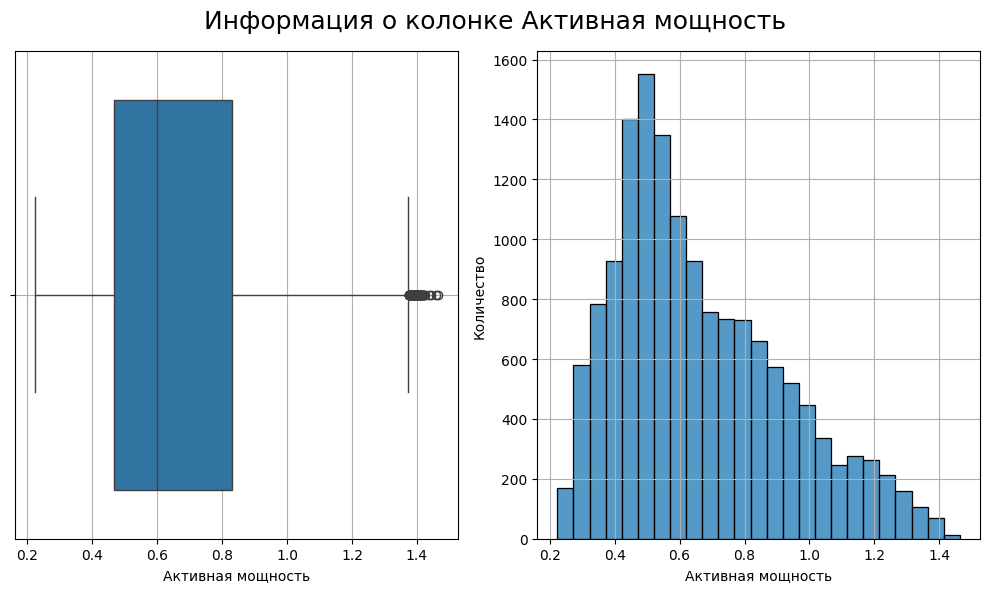

In [19]:
the_basic_plots(data_arc_new, 'Активная мощность', 'Активная мощность')

In [20]:
data_arc_new['Активная мощность'].describe()

count   14876.00
mean        0.66
std         0.26
min         0.22
25%         0.47
50%         0.60
75%         0.83
max         1.46
Name: Активная мощность, dtype: float64

Почти нормальное распределение значений активной мощности со сдвигом пика влево. Среднее и медиана соразмерны.

2. Реактивная мощность:

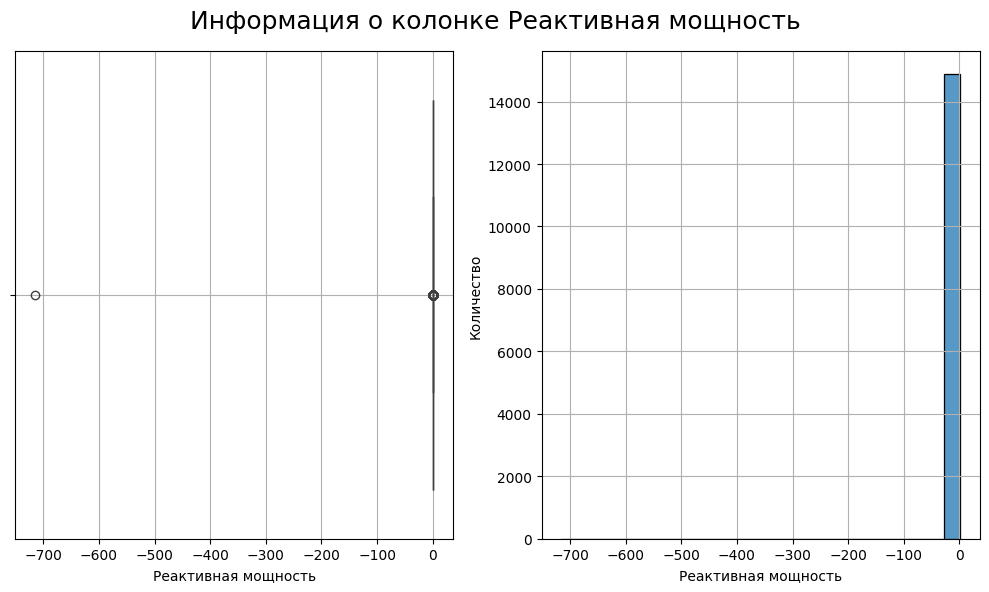

In [21]:
the_basic_plots(data_arc_new, 'Реактивная мощность', 'Реактивная мощность')

Видим явный выброс, рассмотрим его:

In [22]:
data_arc_new[data_arc_new['Реактивная мощность']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.71,-715.48


Удалим значение объекта моделирования-партию 2116, и посмотрим распределение параметра еще раз:

In [23]:
data_arc_new = data_arc_new[~data_arc_new['key'].isin([2116])]

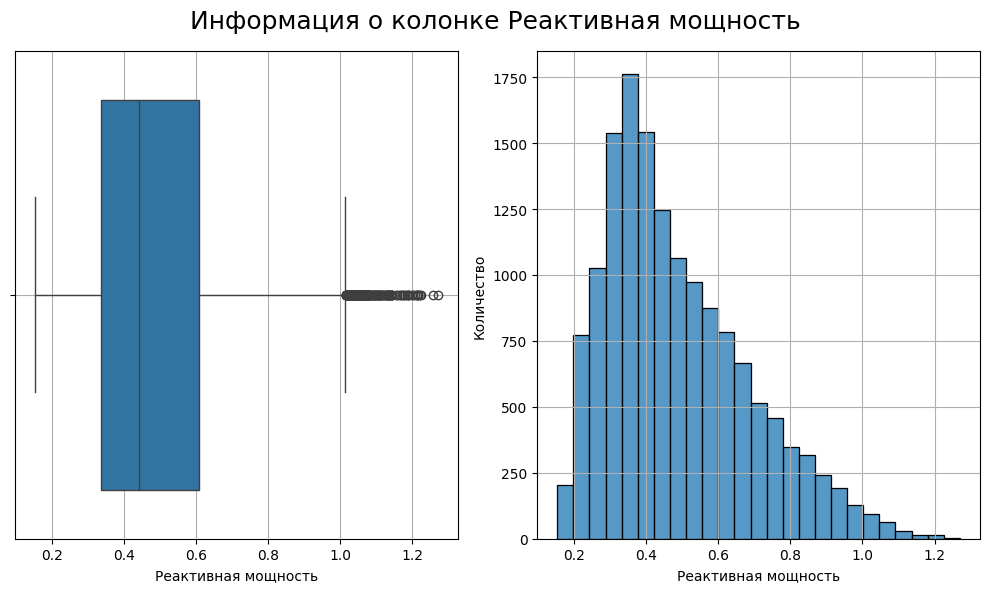

In [24]:
the_basic_plots(data_arc_new, 'Реактивная мощность', 'Реактивная мощность')

In [25]:
data_arc_new['Реактивная мощность'].describe()

count   14872.00
mean        0.49
std         0.20
min         0.15
25%         0.34
50%         0.44
75%         0.61
max         1.27
Name: Реактивная мощность, dtype: float64

Аналогичное активной мощности распределение.

3. Добавим продолжительность нагрева в таблицу и посмотрим распределение:

In [26]:
data_arc_new["Продолжительность нагрева"] = (data_arc_new["Конец нагрева дугой"] - data_arc_new["Начало нагрева дугой"]).dt.seconds

In [27]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.31,0.21,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.77,0.48,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.58,0.43,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.52,0.38,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.87,0.64,148


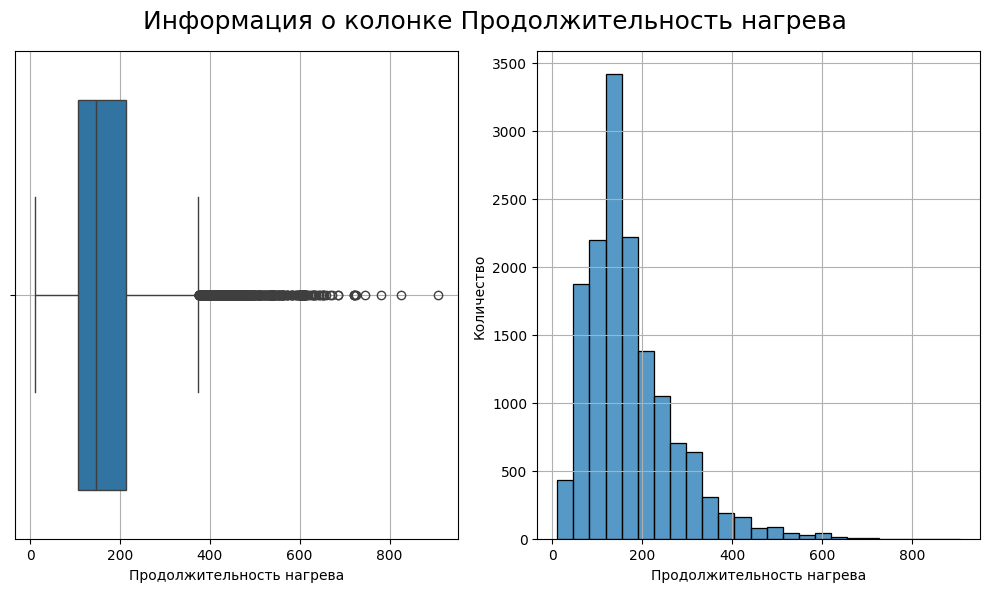

In [28]:
the_basic_plots(data_arc_new, 'Продолжительность нагрева', 'Продолжительность нагрева')

In [29]:
data_arc_new["Продолжительность нагрева"].describe()

count   14872.00
mean      171.69
std        98.19
min        11.00
25%       107.00
50%       147.00
75%       214.00
max       907.00
Name: Продолжительность нагрева, dtype: float64

Такое же околонормальное распределение со сдвигом пика влево.

In [30]:
data_arc_new["Начало нагрева дугой"].describe()

count                            14872
mean     2019-07-05 12:17:07.251008512
min                2019-05-03 11:02:14
25%      2019-06-03 23:00:25.249999872
50%                2019-07-03 01:13:25
75%         2019-08-07 22:59:29.500000
max                2019-09-06 17:24:54
Name: Начало нагрева дугой, dtype: object

In [31]:
data_arc_new["Конец нагрева дугой"].describe()

count                            14872
mean     2019-07-05 12:19:58.939012864
min                2019-05-03 11:06:02
25%      2019-06-03 23:04:15.750000128
50%                2019-07-03 01:15:47
75%                2019-08-07 23:01:33
max                2019-09-06 17:26:15
Name: Конец нагрева дугой, dtype: object

4. Добавим признаки "Полная мощность", "Количество циклов нагрева", "Полное время нагрева", "Итоговая мощность"

In [32]:
data_arc_new = data_arc_new.sort_values(by='key')

In [33]:
data_arc_new["Полная мощность"] = (data_arc_new["Активная мощность"] ** 2 + data_arc_new["Реактивная мощность"] ** 2) ** 0.5
data_arc_new['Энергия'] = data_arc_new['Полная мощность']*data_arc_new['Продолжительность нагрева']

In [34]:
data_arc_new['Количество циклов нагрева'] = data_arc_new.groupby('key')['key'].transform('size')
data_arc_new['Средняя мощность цикла'] = data_arc_new.groupby('key')['Полная мощность'].transform('mean')
data_arc_new['Энергия полного цикла'] = data_arc_new.groupby('key')['Энергия'].transform('sum')
data_arc_new['Полное время нагрева'] = data_arc_new.groupby('key')['Продолжительность нагрева'].transform('sum')

In [35]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева,Полная мощность,Энергия,Количество циклов нагрева,Средняя мощность цикла,Энергия полного цикла,Полное время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.31,0.21,228,0.37,84.62,5,0.74,770.28,1098
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.77,0.48,185,0.90,166.93,5,0.74,770.28,1098
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.58,0.43,172,0.72,124.28,5,0.74,770.28,1098
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.52,0.38,365,0.64,234.63,5,0.74,770.28,1098
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.87,0.64,148,1.08,159.83,5,0.74,770.28,1098


In [36]:
data_arc_new = data_arc_new.drop(['Начало нагрева дугой', 'Конец нагрева дугой','Активная мощность','Реактивная мощность','Продолжительность нагрева','Полная мощность', 'Энергия'], axis=1)

In [37]:
data_arc_new = data_arc_new.drop_duplicates(subset='key', keep='last')

In [38]:
data_arc_new = data_arc_new.sort_values(by='key')

In [39]:
data_arc_new.head()

,key,Количество циклов нагрева,Средняя мощность цикла,Энергия полного цикла,Полное время нагрева
4,1,5,0.74,770.28,1098
8,2,4,0.65,481.76,811
10,3,5,1.00,722.84,655
17,4,4,0.85,683.46,741
21,5,4,0.70,512.17,869


Посмотрим распределение соответствующих новых признаков:

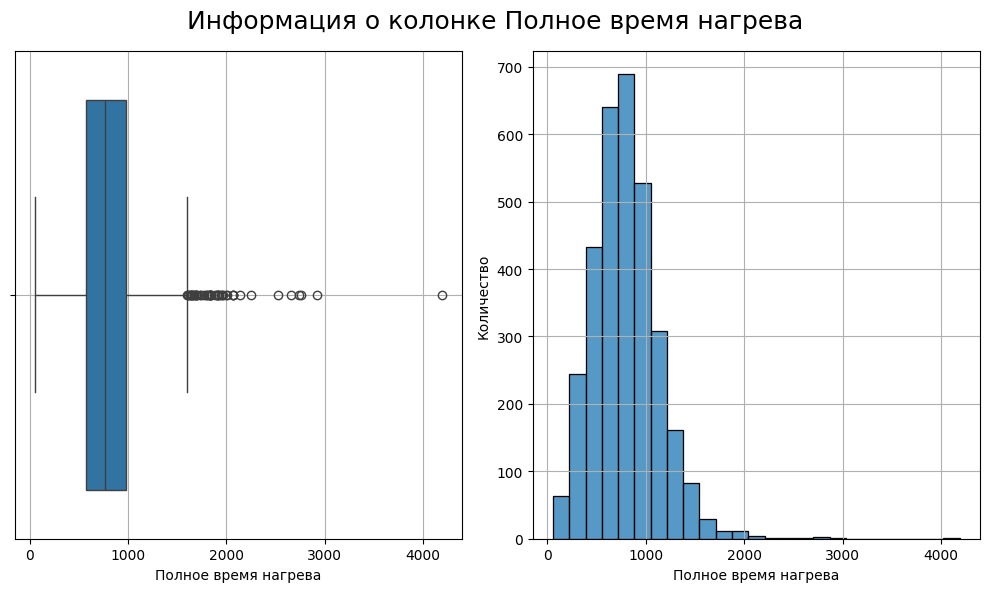

In [40]:
the_basic_plots(data_arc_new, 'Полное время нагрева', 'Полное время нагрева')

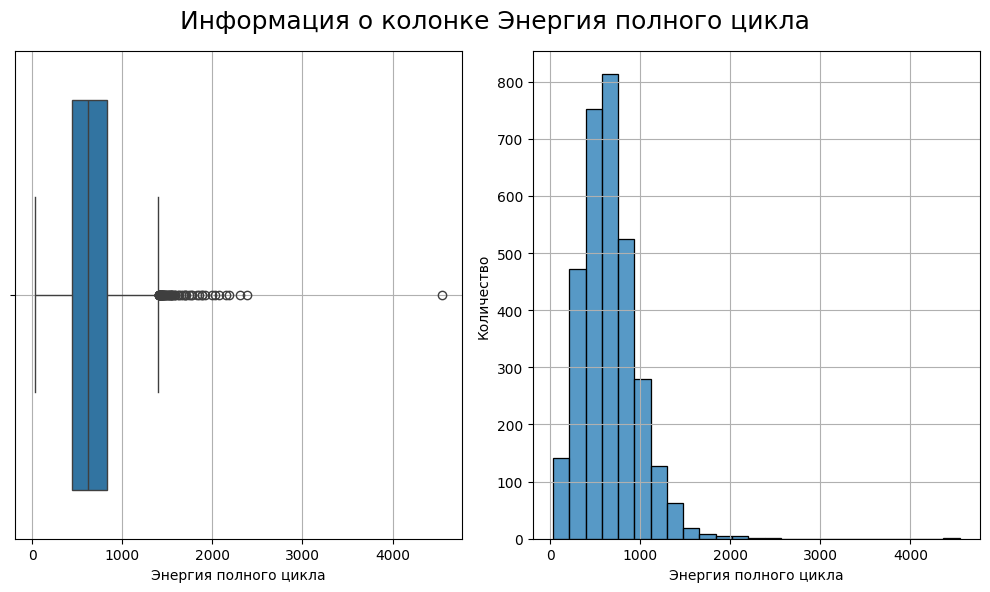

In [41]:
the_basic_plots(data_arc_new, 'Энергия полного цикла', 'Энергия полного цикла')

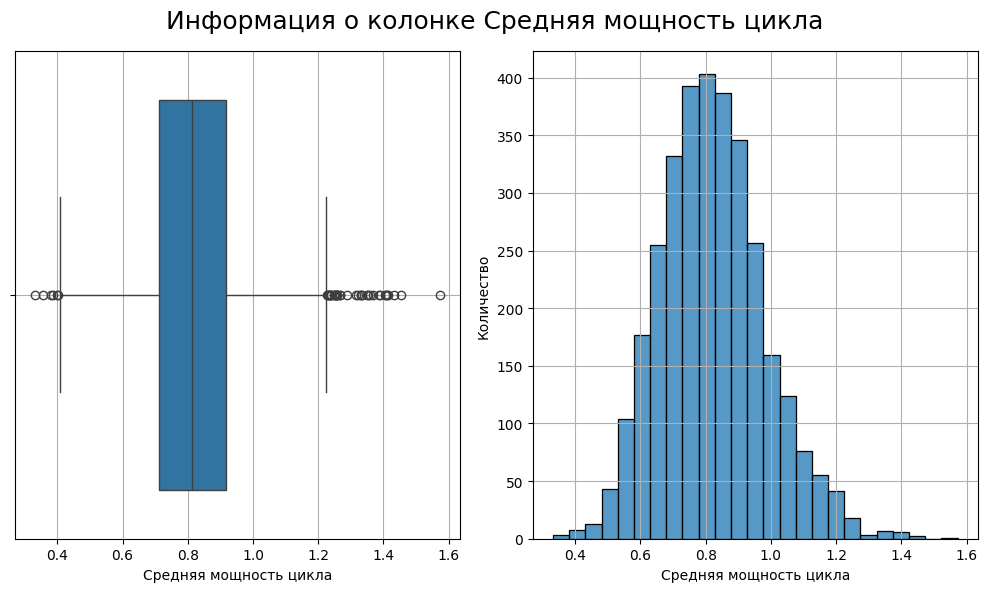

In [42]:
the_basic_plots(data_arc_new, 'Средняя мощность цикла', 'Средняя мощность цикла')

In [43]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3213 entries, 4 to 14875
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   key                        3213 non-null   int64  
 1   Количество циклов нагрева  3213 non-null   int64  
 2   Средняя мощность цикла     3213 non-null   float64
 3   Энергия полного цикла      3213 non-null   float64
 4   Полное время нагрева       3213 non-null   int32  
dtypes: float64(2), int32(1), int64(2)
memory usage: 138.1 KB


**Вывод:** Дубликатов и пропусков в данных нет. Все признаки этого датасета распределены нормально со смещением влево. Создали численный признаки "Количество циклов нагрева", "Полное время нагрева", "Средняя мощность цикла", 'Энергия полного цикла' и удалили ненужные признаки и выбросы.

### <a id='toc2_2_'></a> 2.2 Датафрейм data_bulk_new.csv [&#8593;](#toc0_)

1. Загрузим датафрейм:

In [44]:
data_bulk_new = get_dataframe(['/datasets/data_bulk_new.csv'])

In [45]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,150.00,154.00
1,2,NaN,NaN,NaN,73.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,149.00,154.00
2,3,NaN,NaN,NaN,34.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.00,NaN,152.00,153.00
3,4,NaN,NaN,NaN,81.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.00,NaN,153.00,154.00
4,5,NaN,NaN,NaN,78.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.00,NaN,151.00,152.00


2. Проверим типы данных и пропуски:

In [46]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [47]:
data_bulk_new['key'].value_counts()

key
1       1
2174    1
2152    1
2153    1
2154    1
       ..
1092    1
1093    1
1094    1
1095    1
3241    1
Name: count, Length: 3129, dtype: int64

Сразу видим, что строк меньше, чем сплавов(ключей) в предыдущем датафрейме. В какие-то сплавы, возможно, не добавляли вообще сыпучих материалов.

In [48]:
print_nans_table(data_bulk_new)

+----------+---------------------------------+
| Признаки | Пропущенное количество значений |
+----------+---------------------------------+
|   key    |             0 (0.0%)            |
| Bulk 14  |           323 (10.3%)           |
| Bulk 12  |           679 (21.7%)           |
| Bulk 15  |           881 (28.2%)           |
|  Bulk 3  |           1831 (58.5%)          |
|  Bulk 4  |           2115 (67.6%)          |
|  Bulk 6  |           2553 (81.6%)          |
|  Bulk 1  |           2877 (91.9%)          |
| Bulk 11  |           2952 (94.3%)          |
| Bulk 10  |           2953 (94.4%)          |
|  Bulk 5  |           3052 (97.5%)          |
|  Bulk 7  |           3104 (99.2%)          |
|  Bulk 2  |           3107 (99.3%)          |
|  Bulk 9  |           3110 (99.4%)          |
| Bulk 13  |           3111 (99.4%)          |
|  Bulk 8  |          3128 (100.0%)          |
+----------+---------------------------------+


Какие-то сыпучие материалы не добавлялись в большинство сплавов, заменим пропуски нулями:

In [49]:
data_bulk_new = data_bulk_new.fillna(0)

In [50]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.00,0.00,0.00,43.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,150.00,154.00
1,2,0.00,0.00,0.00,73.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,149.00,154.00
2,3,0.00,0.00,0.00,34.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,205.00,0.00,152.00,153.00
3,4,0.00,0.00,0.00,81.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,207.00,0.00,153.00,154.00
4,5,0.00,0.00,0.00,78.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,203.00,0.00,151.00,152.00


Проверим, есть ли в действительности числа с плавающей точкой в этом датафрейме:

In [51]:
result = data_bulk_new.applymap(has_fractional_part)
result.any(axis=1).sum()

C:\Users\Евгений\AppData\Local\Temp\ipykernel_27800\1374342162.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result = data_bulk_new.applymap(has_fractional_part)


0

Таких чисел нет, поэтому преобразуем типы данных к целочисленным:

In [52]:
data_bulk_new = data_bulk_new.astype(int)

In [53]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      3129 non-null   int32
 1   Bulk 1   3129 non-null   int32
 2   Bulk 2   3129 non-null   int32
 3   Bulk 3   3129 non-null   int32
 4   Bulk 4   3129 non-null   int32
 5   Bulk 5   3129 non-null   int32
 6   Bulk 6   3129 non-null   int32
 7   Bulk 7   3129 non-null   int32
 8   Bulk 8   3129 non-null   int32
 9   Bulk 9   3129 non-null   int32
 10  Bulk 10  3129 non-null   int32
 11  Bulk 11  3129 non-null   int32
 12  Bulk 12  3129 non-null   int32
 13  Bulk 13  3129 non-null   int32
 14  Bulk 14  3129 non-null   int32
 15  Bulk 15  3129 non-null   int32
dtypes: int32(16)
memory usage: 195.7 KB


In [54]:
data_bulk_new['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

In [55]:
data_bulk_new[data_bulk_new['Bulk 8']>0]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1725,1786,0,0,123,0,0,0,0,49,147,0,0,0,0,0,0


8-я добавка только в одном сплаве учитывается, но удалять сейчас ее неправильно, так как потеряем информацию про 1725 сплав с точки зрения общего объема добавок. Рассмотрим удаление данного параметра после исследование общего датафрейма

3. Проверим дубликаты:

In [56]:
data_bulk_new.duplicated().sum()

0

**Далее перейдем к исследовательскому анализу данных(EDA).**

Проанализируем каждый столбец добавок в порядке неуменьшения пропусков(нулевых значений):


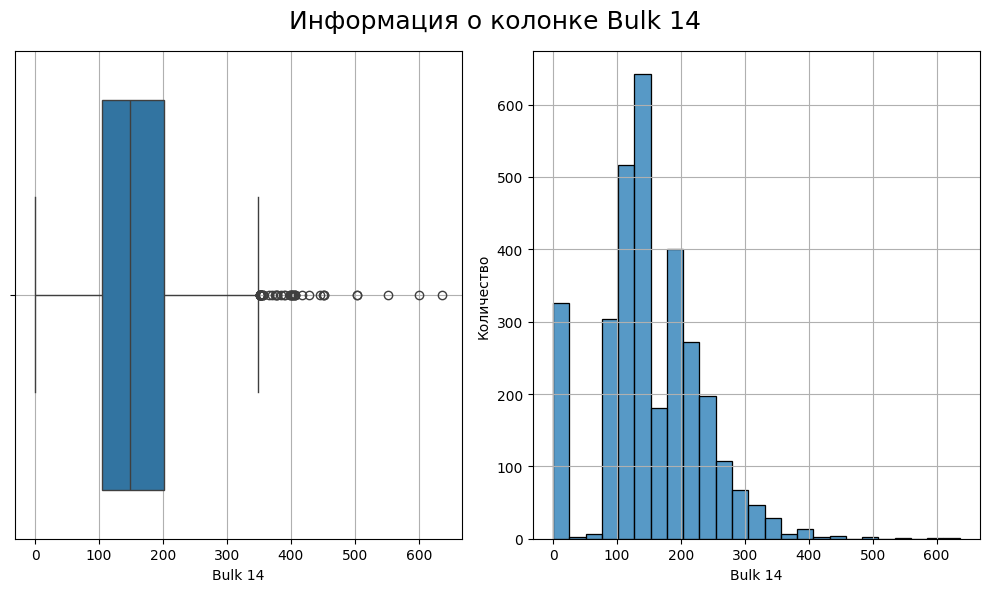

In [57]:
the_basic_plots(data_bulk_new, 'Bulk 14', 'Bulk 14')

In [58]:
data_bulk_new['Bulk 14'].describe()


count   3129.00
mean     152.71
std       81.09
min        0.00
25%      104.00
50%      148.00
75%      202.00
max      636.00
Name: Bulk 14, dtype: float64

Довольно значимая добавка. Распределение даже похоже на нормальное, если не учитывать пропуски.

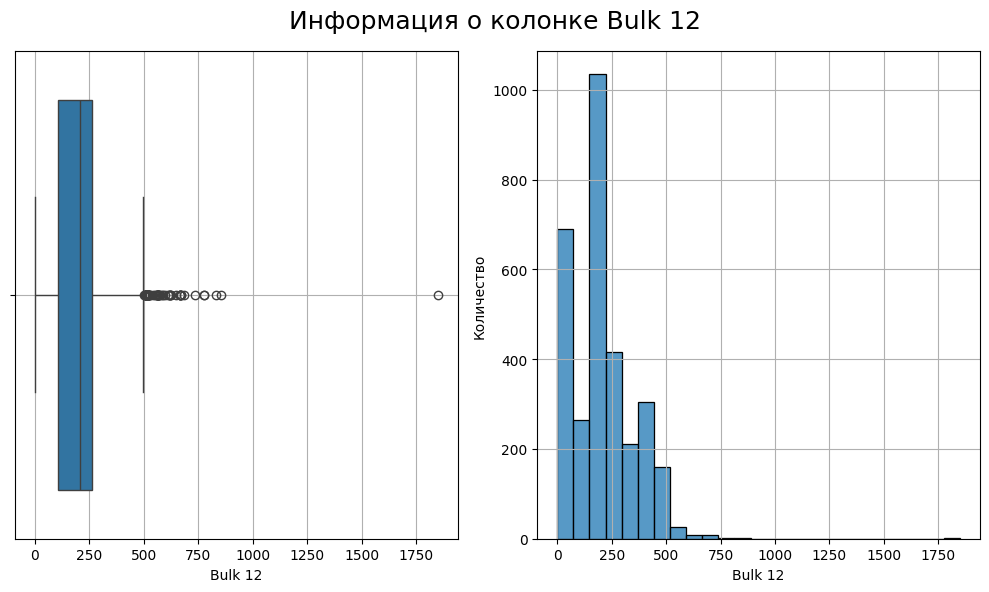

In [59]:
the_basic_plots(data_bulk_new, 'Bulk 12', 'Bulk 12')

In [60]:
data_bulk_new['Bulk 12'].describe()

count   3129.00
mean     203.95
std      151.42
min        0.00
25%      105.00
50%      206.00
75%      263.00
max     1849.00
Name: Bulk 12, dtype: float64

Так же довольно важная добавка с более высоким средним значением

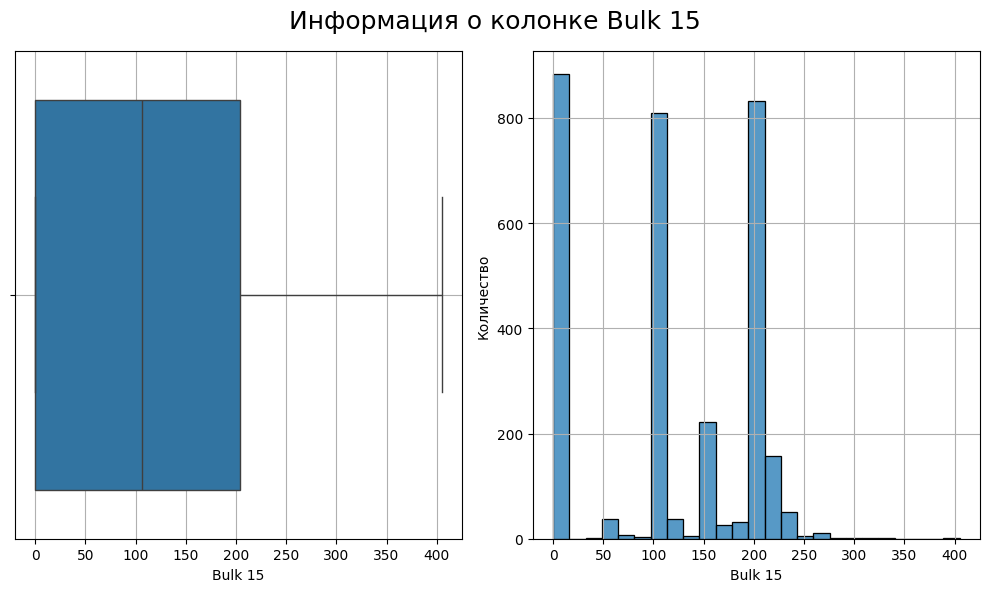

In [61]:
the_basic_plots(data_bulk_new, 'Bulk 15', 'Bulk 15')

In [62]:
data_bulk_new['Bulk 15'].describe()

count   3129.00
mean     115.32
std       84.49
min        0.00
25%        0.00
50%      106.00
75%      204.00
max      405.00
Name: Bulk 15, dtype: float64

Пиковые значения в районе 0, 100 и 200

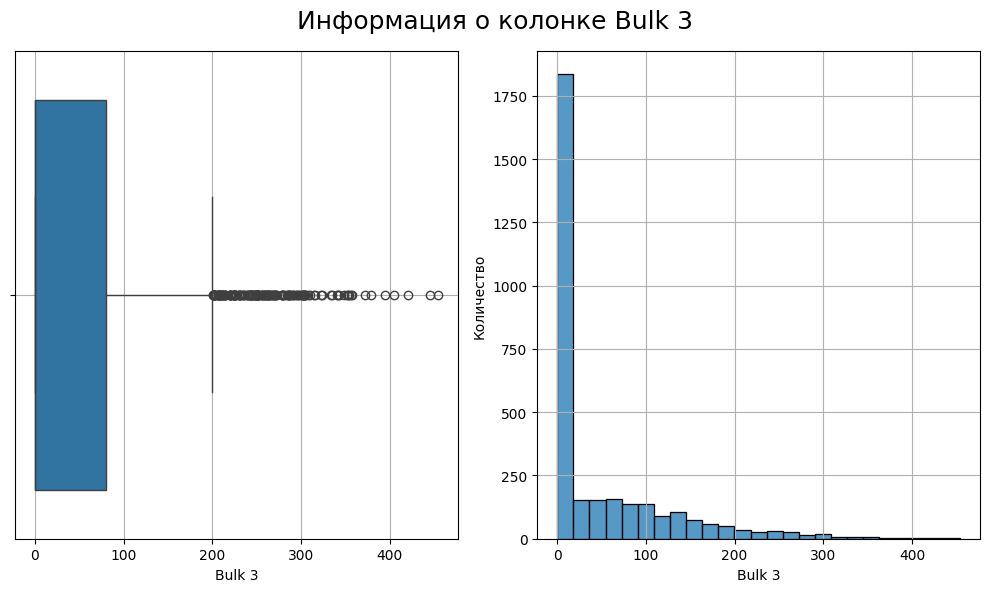

In [63]:
the_basic_plots(data_bulk_new, 'Bulk 3', 'Bulk 3')

In [64]:
data_bulk_new['Bulk 3'].describe()

count   3129.00
mean      47.24
std       74.24
min        0.00
25%        0.00
50%        0.00
75%       80.00
max      454.00
Name: Bulk 3, dtype: float64

Значения объемов 3 добавки обратно пропорциональны количеству их включений в сплавы, начиная от 3 квантиля.

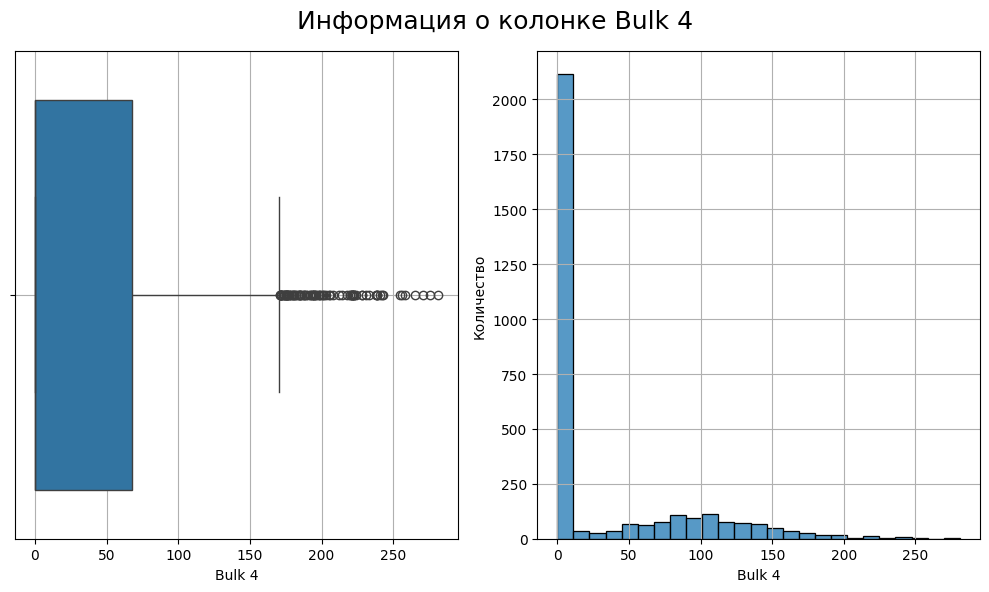

In [65]:
the_basic_plots(data_bulk_new, 'Bulk 4', 'Bulk 4')

In [66]:
data_bulk_new['Bulk 4'].describe()

count   3129.00
mean      33.83
std       56.03
min        0.00
25%        0.00
50%        0.00
75%       68.00
max      281.00
Name: Bulk 4, dtype: float64

Если не учитывать нулевые значения, то распределение этого признака можно считать нормальным с медианным значением в районе 100.

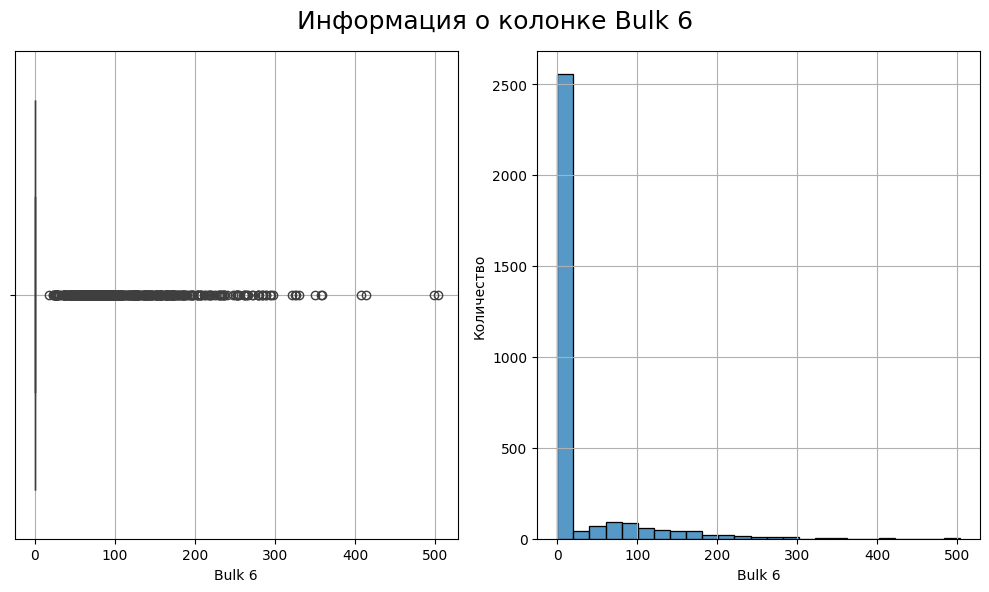

In [67]:
the_basic_plots(data_bulk_new, 'Bulk 6', 'Bulk 6')

In [68]:
data_bulk_new['Bulk 6'].describe()

count   3129.00
mean      21.89
std       55.49
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      503.00
Name: Bulk 6, dtype: float64

Относительно похожая на распределение 4 компонента картинка

В остальных признаках явно сильно больше пропусков, поэтому мы рассмотрим только их распределение по значениям через value_counts() или уникальные значения через unique():

In [69]:
data_bulk_new['Bulk 1'].value_counts()

Bulk 1
0      2877
27       75
46       30
48       16
44       16
31       14
28       11
54       10
34        6
29        6
26        5
22        5
30        5
38        5
62        3
52        3
73        3
39        2
37        2
50        2
92        2
36        2
16        2
24        2
43        2
32        1
19        1
104       1
69        1
74        1
118       1
47        1
78        1
21        1
67        1
63        1
51        1
58        1
83        1
33        1
60        1
65        1
90        1
75        1
94        1
185       1
10        1
41        1
Name: count, dtype: int64

In [70]:
print(sorted(data_bulk_new['Bulk 11'].unique())[::-1])


[313, 242, 226, 225, 211, 206, 205, 204, 200, 198, 188, 185, 178, 176, 174, 172, 162, 158, 156, 154, 152, 151, 148, 146, 144, 140, 139, 136, 133, 131, 128, 126, 124, 120, 114, 107, 106, 104, 103, 102, 100, 98, 97, 96, 95, 94, 93, 91, 90, 89, 88, 87, 84, 83, 82, 81, 76, 74, 72, 71, 69, 68, 67, 66, 64, 62, 58, 56, 54, 53, 51, 50, 49, 48, 47, 46, 43, 42, 41, 40, 39, 38, 37, 34, 32, 31, 29, 28, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 14, 8, 0]


In [71]:
print(sorted(data_bulk_new['Bulk 10'].unique())[::-1])

[159, 154, 147, 128, 126, 125, 124, 122, 118, 117, 115, 114, 113, 111, 110, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 77, 76, 75, 73, 72, 70, 68, 67, 65, 64, 63, 62, 61, 59, 58, 57, 56, 55, 54, 52, 50, 49, 47, 46, 45, 38, 36, 34, 32, 30, 28, 26, 24, 0]


In [72]:
data_bulk_new['Bulk 5'].value_counts()

Bulk 5
0      3052
74        5
72        4
70        3
33        3
120       3
148       2
94        2
132       2
42        2
78        2
142       2
184       2
112       2
86        2
104       1
122       1
197       1
103       1
146       1
54        1
84        1
90        1
234       1
18        1
160       1
50        1
144       1
124       1
128       1
121       1
136       1
256       1
77        1
182       1
242       1
79        1
83        1
189       1
73        1
82        1
102       1
88        1
28        1
43        1
19        1
11        1
23        1
31        1
34        1
22        1
61        1
603       1
180       1
293       1
62        1
Name: count, dtype: int64

In [73]:
data_bulk_new['Bulk 7'].value_counts()

Bulk 7
0      3104
178       1
54        1
108       1
352       1
250       1
462       1
298       1
208       1
296       1
340       1
506       1
405       1
553       1
507       1
392       1
306       1
576       1
772       1
92        1
47        1
252       1
155       1
75        1
406       1
50        1
Name: count, dtype: int64

In [74]:
data_bulk_new['Bulk 2'].value_counts()

Bulk 2
0      3107
254       4
228       2
242       2
258       2
270       2
247       1
232       1
325       1
257       1
233       1
248       1
249       1
282       1
246       1
236       1
Name: count, dtype: int64

In [75]:
data_bulk_new['Bulk 9'].value_counts()

Bulk 9
0      3110
68        4
66        4
70        3
65        2
63        1
71        1
147       1
111       1
108       1
74        1
Name: count, dtype: int64

In [76]:
data_bulk_new['Bulk 13'].value_counts()

Bulk 13
0      3111
154       3
153       3
159       1
278       1
155       1
157       1
204       1
151       1
305       1
156       1
214       1
206       1
202       1
152       1
Name: count, dtype: int64

In [77]:
data_bulk_new['Bulk 8'].value_counts()

Bulk 8
0     3128
49       1
Name: count, dtype: int64

Попробуем добавить столбец с суммой объемов всех добавок и посмотрим на его распределение:

In [78]:
data_bulk_new.columns

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

In [79]:
data_bulk_new['Общий объем добавок'] = data_bulk_new[['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15']].sum(axis=1)

In [80]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Общий объем добавок
0,1,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154,553
1,2,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154,582
2,3,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153,544
3,4,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154,595
4,5,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152,584


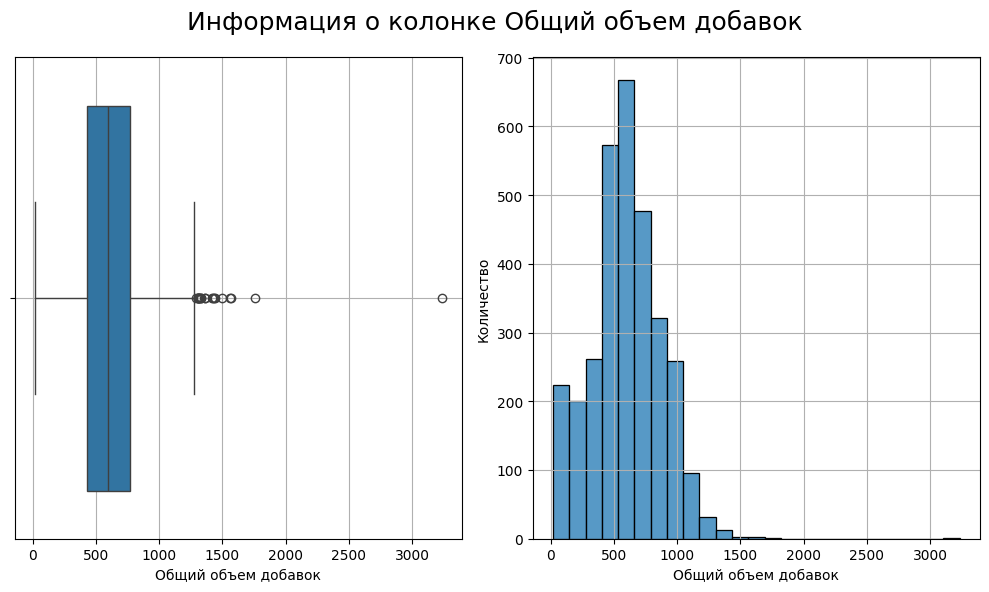

In [81]:
the_basic_plots(data_bulk_new, 'Общий объем добавок', 'Общий объем добавок')

In [82]:
data_bulk_new['Общий объем добавок'].describe()

count   3129.00
mean     595.50
std      276.56
min       19.00
25%      429.00
50%      591.00
75%      772.00
max     3235.00
Name: Общий объем добавок, dtype: float64

In [83]:
data_bulk_new = data_bulk_new.sort_values(by='key')

In [84]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Общий объем добавок
0,1,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154,553
1,2,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154,582
2,3,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153,544
3,4,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154,595
4,5,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152,584


In [85]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   key                  3129 non-null   int32
 1   Bulk 1               3129 non-null   int32
 2   Bulk 2               3129 non-null   int32
 3   Bulk 3               3129 non-null   int32
 4   Bulk 4               3129 non-null   int32
 5   Bulk 5               3129 non-null   int32
 6   Bulk 6               3129 non-null   int32
 7   Bulk 7               3129 non-null   int32
 8   Bulk 8               3129 non-null   int32
 9   Bulk 9               3129 non-null   int32
 10  Bulk 10              3129 non-null   int32
 11  Bulk 11              3129 non-null   int32
 12  Bulk 12              3129 non-null   int32
 13  Bulk 13              3129 non-null   int32
 14  Bulk 14              3129 non-null   int32
 15  Bulk 15              3129 non-null   int32
 16  Общий объем добавок  312

**Вывод**:

Провели первичную предобработку данных, дубликатов не оказалось. Много пропусков в большинстве значений добавок. Пропуски заменили нулями, проанализировали значения каждого столбца и в силу соразмерности объемов сыпучих добавок ввели новый параметр: общий объем добавок, который скорее всего и будет итоговым влияющим признаком данного датафрейма. 


### <a id='toc2_3_'></a> 2.3 Датафрейм data_bulk_time_new.csv [&#8593;](#toc0_)

1. Загрузим датафрейм:

In [86]:
data_bulk_time_new = get_dataframe(['/datasets/data_bulk_time_new.csv'])

In [87]:
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


2. Проверим типы данных и пропуски:

In [88]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [89]:
data_bulk_time_new['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241], dtype=int64)

In [90]:
data_bulk_time_new['key'].value_counts()

key
1       1
2174    1
2152    1
2153    1
2154    1
       ..
1092    1
1093    1
1094    1
1095    1
3241    1
Name: count, Length: 3129, dtype: int64

2. Проверим пропущенные значения и заменим после этого их на нули:

In [91]:
print_nans_table(data_bulk_time_new)

+----------+---------------------------------+
| Признаки | Пропущенное количество значений |
+----------+---------------------------------+
|   key    |             0 (0.0%)            |
| Bulk 14  |           323 (10.3%)           |
| Bulk 12  |           679 (21.7%)           |
| Bulk 15  |           881 (28.2%)           |
|  Bulk 3  |           1831 (58.5%)          |
|  Bulk 4  |           2115 (67.6%)          |
|  Bulk 6  |           2553 (81.6%)          |
|  Bulk 1  |           2877 (91.9%)          |
| Bulk 11  |           2952 (94.3%)          |
| Bulk 10  |           2953 (94.4%)          |
|  Bulk 5  |           3052 (97.5%)          |
|  Bulk 7  |           3104 (99.2%)          |
|  Bulk 2  |           3107 (99.3%)          |
|  Bulk 9  |           3110 (99.4%)          |
| Bulk 13  |           3111 (99.4%)          |
|  Bulk 8  |          3128 (100.0%)          |
+----------+---------------------------------+


In [92]:
data_bulk_time_new.iloc[:, 1:] = data_bulk_time_new.iloc[:, 1:].apply(pd.to_datetime,errors='coerce')

In [93]:
data_bulk_time_new = data_bulk_time_new.fillna(0)

In [94]:
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0,0,0,2019-05-03 11:28:48,0,0,0,0,0,0,0,2019-05-03 11:24:31,0,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,0,0,0,2019-05-03 11:36:50,0,0,0,0,0,0,0,2019-05-03 11:53:30,0,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,0,0,0,2019-05-03 12:32:39,0,0,0,0,0,0,0,2019-05-03 12:27:13,0,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,0,0,0,2019-05-03 12:43:22,0,0,0,0,0,0,0,2019-05-03 12:58:00,0,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,0,0,0,2019-05-03 13:30:47,0,0,0,0,0,0,0,2019-05-03 13:30:47,0,2019-05-03 13:34:12,2019-05-03 13:30:47


3. Проверим дубликаты:

In [95]:
data_bulk_time_new.duplicated().sum()

0

In [96]:
data_bulk_time_new.describe(include='all')

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00,3129.00
unique,NaN,253.00,23.00,1299.00,1015.00,78.00,577.00,26.00,2.00,20.00,177.00,178.00,2451.00,19.00,2807.00,2249.00
top,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
freq,NaN,2877.00,3107.00,1831.00,2115.00,3052.00,2553.00,3104.00,3128.00,3110.00,2953.00,2952.00,679.00,3111.00,323.00,881.00
mean,1624.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,933.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,816.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1622.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2431.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Вывод**:

Типы данных преобразовали в даты. Пропуски, очевидно, такие же как и в предыдущем датафрейме с объемами добавок. Данный датафрейм по сути является избыточным, поэтому мы попросту исключим из рассмотрения ввиду избыточности.


### <a id='toc2_4_'></a> 2.4 Датафрейм data_gas_new.csv [&#8593;](#toc0_)

1. Загрузим датафрейм:

In [97]:
data_gas_new = get_dataframe(['/datasets/data_gas_new.csv'])

In [98]:
data_gas_new.head()

,key,Газ 1
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84
4,5,5.41


2. Проверим типы данных и пропуски:

In [99]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [100]:
data_gas_new['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241], dtype=int64)

In [101]:
data_gas_new['key'].value_counts()

key
1       1
2166    1
2156    1
2157    1
2158    1
       ..
1086    1
1087    1
1088    1
1089    1
3241    1
Name: count, Length: 3239, dtype: int64

In [102]:
print_nans_table(data_gas_new)

+----------+---------------------------------+
| Признаки | Пропущенное количество значений |
+----------+---------------------------------+
|   key    |             0 (0.0%)            |
|  Газ 1   |             0 (0.0%)            |
+----------+---------------------------------+


Пропущенных значений нет и уникальных значений ключей сплавов больше, чем в каком либо датасете до этого.

3. Проверим дубликаты:

In [103]:
data_gas_new.duplicated().sum()

0

**Далее перейдем к исследовательскому анализу данных(EDA).**

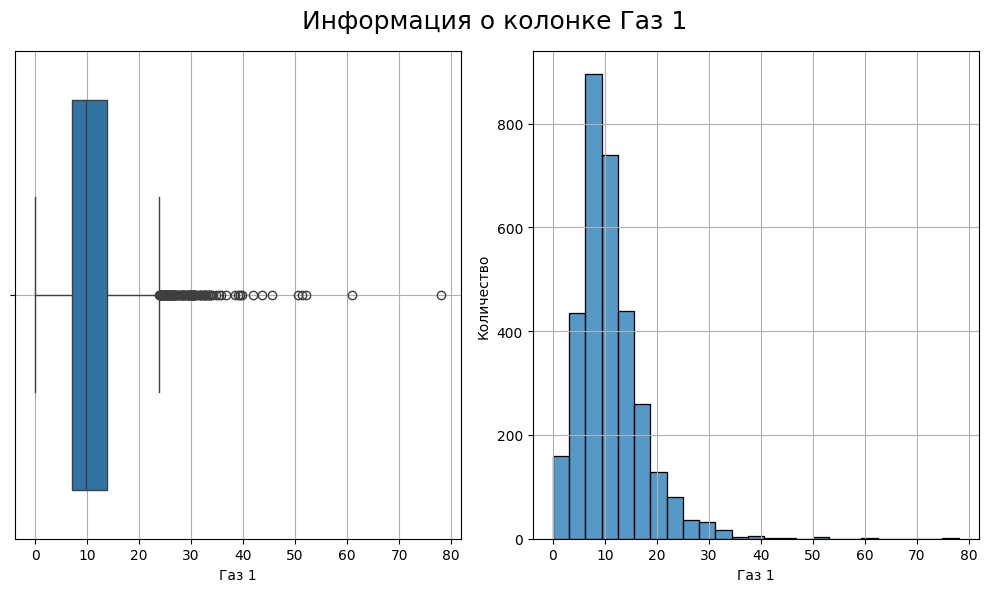

In [104]:
the_basic_plots(data_gas_new, 'Газ 1', 'Газ 1')

In [105]:
data_gas_new = data_gas_new.sort_values(by='key')

In [106]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


**Вывод**: Значений ключей сплавов уникальных 3239, это больше, чем в остальных датасетах. Пропусков и дубликатов нет. Объем газа - нормально распределенная величина с небольшим сдвигом влево.

### <a id='toc2_5_'></a> 2.5 Датафрейм data_temp_new.csv [&#8593;](#toc0_)

1. Загрузим датафрейм:

In [107]:
data_temp_new = get_dataframe(['/datasets/data_temp_new.csv'])

In [108]:
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.00
1,1,2019-05-03 11:07:18,1604.00
2,1,2019-05-03 11:11:34,1618.00
3,1,2019-05-03 11:18:04,1601.00
4,1,2019-05-03 11:25:59,1606.00


2. Проверим типы данных и пропуски:

In [109]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [110]:
data_temp_new['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241], dtype=int64)

In [111]:
data_temp_new['key'].value_counts()

key
2108    17
1513    16
1689    16
2567    15
46      14
        ..
247      2
1169     2
246      2
195      1
279      1
Name: count, Length: 3216, dtype: int64

Уникальных значений ключей 3216, что меньше, чем в таблице с объемами газа и почти столько же, сколько в первом датафрейме со значениями мощностей(3214).

In [112]:
print_nans_table(data_temp_new)

+--------------+---------------------------------+
|   Признаки   | Пропущенное количество значений |
+--------------+---------------------------------+
|     key      |             0 (0.0%)            |
| Время замера |             0 (0.0%)            |
| Температура  |           3427 (18.9%)          |
+--------------+---------------------------------+


In [113]:
data_temp_new[data_temp_new['Температура'].isna()== True]

,key,Время замера,Температура
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


Почти 1/5 часть замеров не содержит значений температуры. Однако мы не сможем заменить значения данных температур, так как это является целевым признаком. Стоит удалить партии с пропусками в измерениях температуры:

In [114]:
keys_with_nans = data_temp_new[data_temp_new['Температура'].isna()== True]['key'].unique()
keys_with_nans

array([2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510,
       2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521,
       2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532,
       2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543,
       2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554,
       2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565,
       2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576,
       2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587,
       2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598,
       2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609,
       2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620,
       2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631,
       2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642,
       2643, 2644, 2645, 2646, 2647, 2648, 2649, 26

In [115]:
data_temp_new = data_temp_new[~data_temp_new['key'].isin(keys_with_nans)]

In [116]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13926 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           13926 non-null  int64  
 1   Время замера  13926 non-null  object 
 2   Температура   13926 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 435.2+ KB


Проверим, есть ли в действительности значения температуры с плавающей точкой:

In [117]:
result = data_temp_new.applymap(has_fractional_part)
result.any(axis=1).sum()

C:\Users\Евгений\AppData\Local\Temp\ipykernel_27800\1542300688.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result = data_temp_new.applymap(has_fractional_part)


0

Заменим типы данных на соответствующие:

In [118]:
data_temp_new['Время замера'] = data_temp_new['Время замера'].apply(pd.to_datetime, errors='coerce')

In [119]:
data_temp_new['Температура'] = data_temp_new['Температура'].astype(int)

In [120]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13926 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13926 non-null  int64         
 1   Время замера  13926 non-null  datetime64[ns]
 2   Температура   13926 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(1)
memory usage: 380.8 KB


3. Проверим дубликаты:

In [121]:
data_temp_new.duplicated().sum()

0

**Далее перейдем к исследовательскому анализу данных(EDA).**

1. Столбец "Время замера"

In [122]:
data_temp_new['Время замера'].describe()

count                            13926
mean     2019-06-20 17:50:40.798219008
min                2019-05-03 11:02:04
25%                2019-05-27 00:14:53
50%         2019-06-19 13:37:12.500000
75%      2019-07-11 20:10:10.249999872
max                2019-08-10 13:58:58
Name: Время замера, dtype: object

Выбивающихся, с точки зрения сильно выбивающихся,значений нет

2. Столбец "Температура"

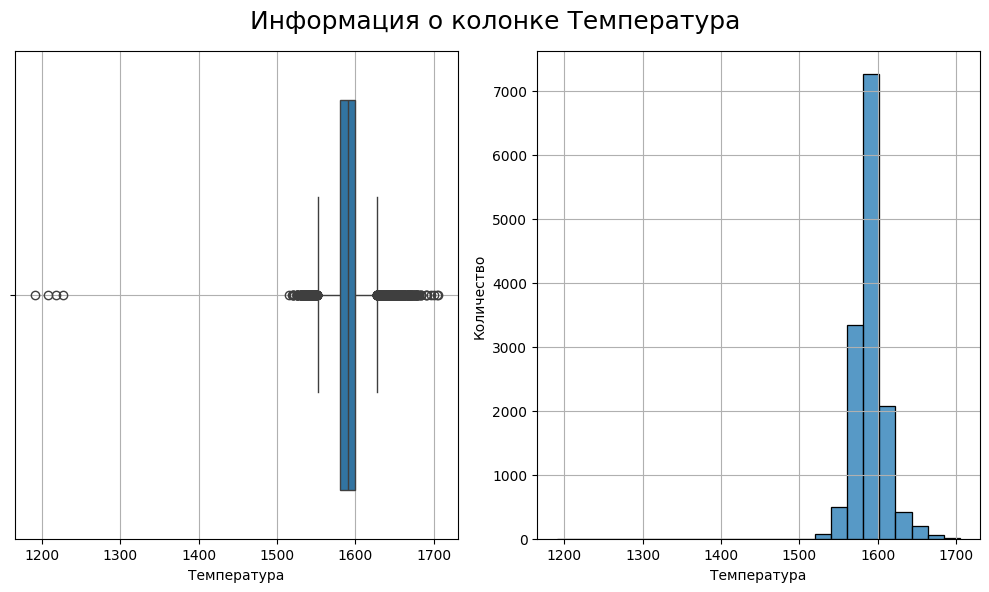

In [123]:
the_basic_plots(data_temp_new, 'Температура', 'Температура')

In [124]:
data_temp_new['Температура'].describe()

count   13926.00
mean     1590.80
std        19.85
min      1191.00
25%      1580.00
50%      1590.00
75%      1599.00
max      1705.00
Name: Температура, dtype: float64

Уберем данные с выбросами по начальной температуре < 1400 строки:

In [125]:
keys_with_low_temp = data_temp_new[data_temp_new['Температура']<1400]['key'].unique()
data_temp_new = data_temp_new[~data_temp_new['key'].isin(keys_with_low_temp)]

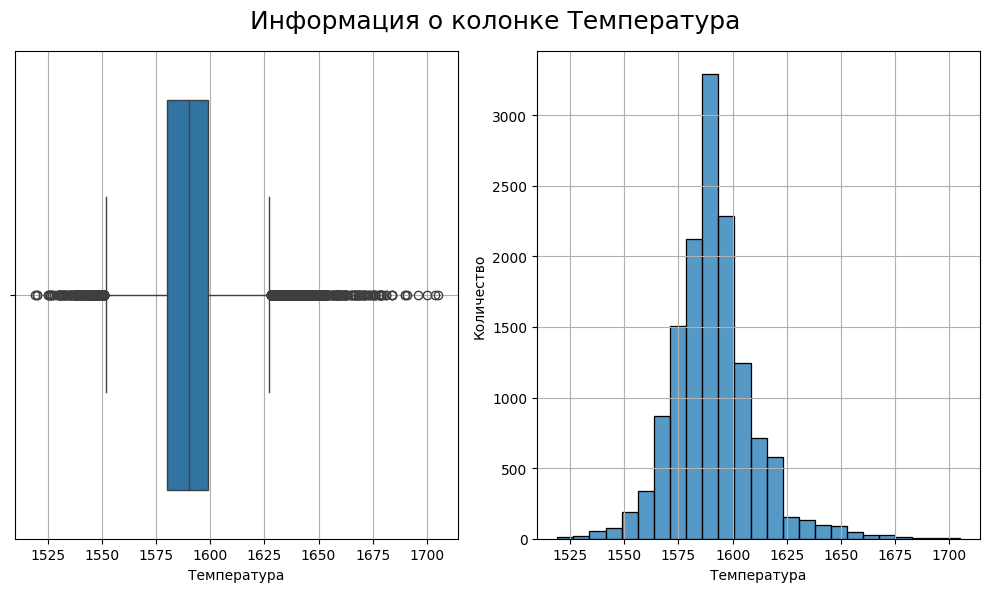

In [126]:
the_basic_plots(data_temp_new, 'Температура', 'Температура')

Далее добавим столбцы с начальной и конечной(target) температурами. После чего удалим строки с промежуточными измерениями температуры.

In [127]:
data_temp_new = data_temp_new.sort_values(by=['key', 'Время замера'])

In [128]:
last_temp = data_temp_new.groupby('key').apply(lambda x: x.loc[x['Время замера'].idxmax(), 'Температура'])
first_temp = data_temp_new.groupby('key').apply(lambda x: x.loc[x['Время замера'].idxmin(), 'Температура'])

C:\Users\Евгений\AppData\Local\Temp\ipykernel_27800\2639740615.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_temp = data_temp_new.groupby('key').apply(lambda x: x.loc[x['Время замера'].idxmax(), 'Температура'])
C:\Users\Евгений\AppData\Local\Temp\ipykernel_27800\2639740615.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_temp = data_temp_new.groupby('key').apply(lambda x: x.loc[x['Время 

In [129]:
data_temp_new['Начальная температура'] = data_temp_new['key'].map(first_temp)
data_temp_new['Итоговая температура'] = data_temp_new['key'].map(last_temp)

In [130]:
data_temp_new.head(10)

,key,Время замера,Температура,Начальная температура,Итоговая температура
0,1,2019-05-03 11:02:04,1571,1571,1613
1,1,2019-05-03 11:07:18,1604,1571,1613
2,1,2019-05-03 11:11:34,1618,1571,1613
3,1,2019-05-03 11:18:04,1601,1571,1613
4,1,2019-05-03 11:25:59,1606,1571,1613
5,1,2019-05-03 11:30:38,1613,1571,1613
6,2,2019-05-03 11:34:04,1581,1581,1602
7,2,2019-05-03 11:38:40,1577,1581,1602
8,2,2019-05-03 11:46:09,1589,1581,1602
9,2,2019-05-03 11:49:38,1604,1581,1602


In [131]:
data_temp_new[data_temp_new['Начальная температура'] == data_temp_new['Итоговая температура']]

,key,Время замера,Температура,Начальная температура,Итоговая температура
352,63,2019-05-05 22:04:48,1580,1580,1580
353,63,2019-05-05 22:11:48,1584,1580,1580
354,63,2019-05-05 22:18:38,1578,1580,1580
355,63,2019-05-05 22:29:16,1578,1580,1580
356,63,2019-05-05 22:36:23,1580,1580,1580
...,...,...,...,...,...
13250,2371,2019-08-05 23:52:57,1623,1623,1623
13847,2483,2019-08-09 22:55:31,1598,1598,1598
13848,2483,2019-08-09 23:11:51,1618,1598,1598
13849,2483,2019-08-09 23:19:32,1597,1598,1598


Посмотрим на оставшиеся с одним начальным измерением партии и удалим их из датафрейма:

In [132]:
data_temp_new.groupby('key').filter(lambda x: len(x) == 1)

,key,Время замера,Температура,Начальная температура,Итоговая температура
1105,195,2019-05-11 00:01:36,1583,1583,1583
1549,279,2019-05-14 10:13:01,1603,1603,1603


In [133]:
data_temp_new.shape

(13905, 5)

In [134]:
data_temp_new = data_temp_new.groupby('key').filter(lambda x: len(x) > 1)

In [135]:
data_temp_new.shape

(13903, 5)

In [136]:
data_temp_new = data_temp_new.drop_duplicates(subset='key', keep='last')

Теперь удалим ненужные столбцы "Температура" и "Время замера":

In [137]:
data_temp_new = data_temp_new.drop(['Температура', 'Время замера'], axis=1)

In [138]:
data_temp_new.head(5)

,key,Начальная температура,Итоговая температура
5,1,1571,1613
10,2,1581,1602
16,3,1596,1599
21,4,1601,1625
26,5,1576,1602


In [139]:
data_temp_new.shape

(2471, 3)

In [140]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2471 entries, 5 to 13925
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   key                    2471 non-null   int64
 1   Начальная температура  2471 non-null   int32
 2   Итоговая температура   2471 non-null   int32
dtypes: int32(2), int64(1)
memory usage: 57.9 KB


In [141]:
data_temp_new = data_temp_new.sort_values(by='key')

**Вывод**: Значений ключей сплавов уникальных 2471. Пропуски удалили, дубликатов нет. Значения температур распределены относительно нормально. Для моделей нам понадобятся значения начальных и конечных температур, которые мы зафиксировали в датафрейме, остальные столбцы убрали.

### <a id='toc2_6_'></a> 2.6 Датафрейм data_wire_new.csv [&#8593;](#toc0_)

1. Загрузим датафрейм:

In [142]:
data_wire_new = get_dataframe(['/datasets/data_wire_new.csv'])

In [143]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.24,9.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2. Проверим типы данных и пропуски

In [144]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [145]:
data_wire_new['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241], dtype=int64)

In [146]:
data_wire_new['key'].value_counts()

key
1       1
2226    1
2146    1
2147    1
2148    1
       ..
1090    1
1091    1
1092    1
1093    1
3241    1
Name: count, Length: 3081, dtype: int64

In [147]:
print_nans_table(data_wire_new)

+----------+---------------------------------+
| Признаки | Пропущенное количество значений |
+----------+---------------------------------+
|   key    |             0 (0.0%)            |
|  Wire 1  |            26 (0.8%)            |
|  Wire 2  |           2002 (65.0%)          |
|  Wire 6  |           3008 (97.6%)          |
|  Wire 3  |           3018 (98.0%)          |
|  Wire 9  |           3052 (99.1%)          |
|  Wire 8  |           3062 (99.4%)          |
|  Wire 4  |           3067 (99.5%)          |
|  Wire 7  |           3070 (99.6%)          |
|  Wire 5  |          3080 (100.0%)          |
+----------+---------------------------------+


Большая часть значений по объемам подаваемых проволочных материалов пропущена. Уникальных значений ключей(партий) сплавов меньше, чем было в других датасетах. Видимо, проволочные материалы добавляются еще реже сыпучих 

3. Проверим дубликаты

In [148]:
data_wire_new.duplicated().sum()

0

Дубликатов нет. Заменим пропуски на нули:

In [149]:
data_wire_new = data_wire_new.fillna(0)

In [150]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2,96.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,3,91.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,4,89.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,5,89.24,9.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00


**Далее перейдем к исследовательскому анализу данных(EDA).**

In [151]:
data_wire_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.00,3081.00,3081.00,3081.00,3081.00,3081.00,3081.00,3081.00,3081.00,3081.00
mean,1623.43,100.04,17.71,3.87,0.26,0.00,1.14,0.04,0.33,0.32
std,933.00,42.84,33.52,30.31,4.29,0.27,8.96,0.77,4.39,3.81
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,823.00,70.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1619.00,100.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2434.00,125.80,23.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,3241.00,330.31,282.78,385.01,113.23,15.13,180.45,32.85,102.76,90.05


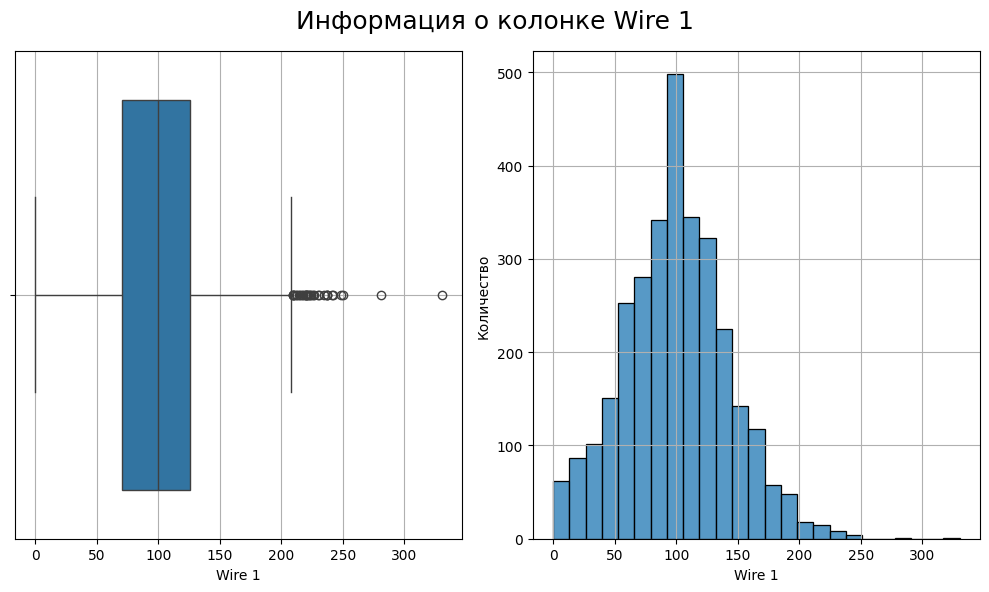

In [152]:
the_basic_plots(data_wire_new, 'Wire 1', 'Wire 1')

Почти во все партии первый проволочный материал попадает. Его распределение нормальное.

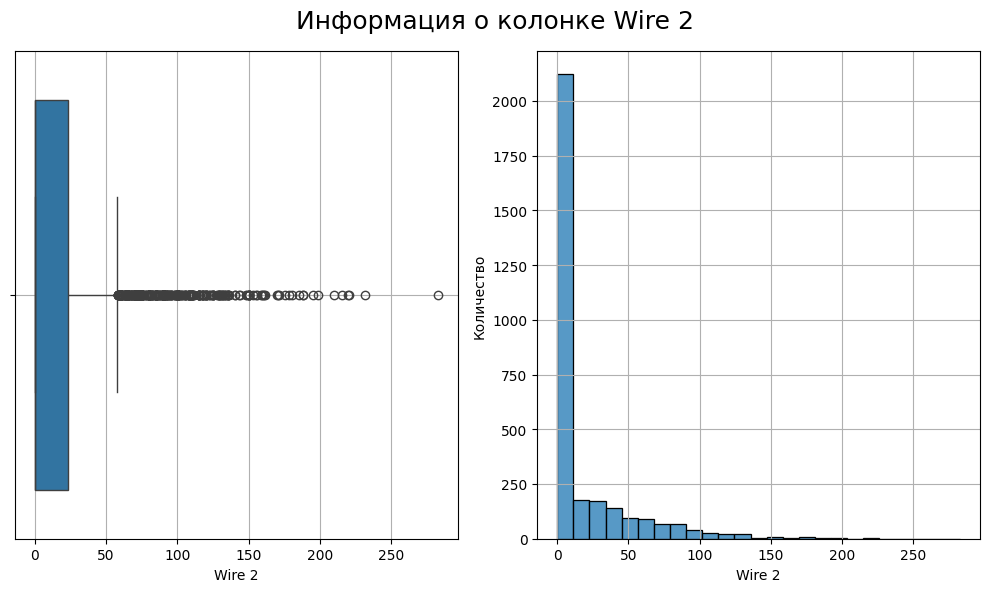

In [153]:
the_basic_plots(data_wire_new, 'Wire 2', 'Wire 2')

Обратно-пропорциональная зависимость прослеживается если не брать во внимание нулевые значения.

In [154]:
data_wire_new = data_wire_new.sort_values(by='key')

In [155]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


**Вывод**: Значений ключей сплавов уникальных 3081. Пропуски заменили нулями, дубликтаов нет. Объем первого проволочного материала и распределен нормально. 

### <a id='toc2_7_'></a> 2.7 Датафрейм data_wire_time_new.csv [&#8593;](#toc0_)

1. Загрузка датафрейма

In [156]:
data_wire_time_new = get_dataframe(['/datasets/data_wire_time_new.csv'])

In [157]:
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2. Рассмотрим типы данных и пропуски

In [158]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [159]:
print_nans_table(data_wire_time_new)

+----------+---------------------------------+
| Признаки | Пропущенное количество значений |
+----------+---------------------------------+
|   key    |             0 (0.0%)            |
|  Wire 1  |            26 (0.8%)            |
|  Wire 2  |           2002 (65.0%)          |
|  Wire 6  |           3008 (97.6%)          |
|  Wire 3  |           3018 (98.0%)          |
|  Wire 9  |           3052 (99.1%)          |
|  Wire 8  |           3062 (99.4%)          |
|  Wire 4  |           3067 (99.5%)          |
|  Wire 7  |           3070 (99.6%)          |
|  Wire 5  |          3080 (100.0%)          |
+----------+---------------------------------+


Очевидно ситуация такая же, как и в датафрейме с объемами проволочных материалов.

In [160]:
data_wire_time_new['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241], dtype=int64)

In [161]:
data_wire_time_new['key'].value_counts()

key
1       1
2226    1
2146    1
2147    1
2148    1
       ..
1090    1
1091    1
1092    1
1093    1
3241    1
Name: count, Length: 3081, dtype: int64

In [162]:
data_wire_time_new.iloc[:, 1:] = data_wire_time_new.iloc[:, 1:].apply(pd.to_datetime,errors='coerce')

In [163]:
data_wire_time_new = data_wire_time_new.fillna(0)

In [164]:
data_wire_time_new.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,0,0,0,0,0,0,0,0
1,2,2019-05-03 11:36:50,0,0,0,0,0,0,0,0
2,3,2019-05-03 12:11:46,0,0,0,0,0,0,0,0
3,4,2019-05-03 12:43:22,0,0,0,0,0,0,0,0
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,0,0,0,0,0,0,0
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,0,0,0,0,0,0,0
6,7,2019-05-03 14:18:58,0,0,0,0,0,0,0,0
7,8,2019-05-03 15:01:30,0,0,0,0,0,0,0,0
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,0,0,0,0,0,0,0
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,0,0,0,0,0,0,0


In [165]:
data_wire_time_new.describe(include= 'all')

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.00,3081.00,3081.00,3081.00,3081.00,3081.00,3081.00,3081.00,3081.00,3081.00
unique,NaN,3056.00,1080.00,64.00,15.00,2.00,74.00,12.00,20.00,30.00
top,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
freq,NaN,26.00,2002.00,3018.00,3067.00,3080.00,3008.00,3070.00,3062.00,3052.00
mean,1623.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,933.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,823.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1619.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2434.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Вывод**: Такой же датафрейм, как и предыдущий с объемами проволочных материалов. Данный датафрейм внесет избыточность в данные, так же как и датафрейм со временем подачи сыпучих материалов, так что в итоговом датафрейме его использовать не будем.

## <a id='toc3_'></a> 3. Объединение данных [&#8593;](#toc0_)

In [166]:
merged_df_t_a = pd.merge(data_temp_new, data_arc_new, on='key', how='inner')

In [167]:
merged_df_t_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470 entries, 0 to 2469
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   key                        2470 non-null   int64  
 1   Начальная температура      2470 non-null   int32  
 2   Итоговая температура       2470 non-null   int32  
 3   Количество циклов нагрева  2470 non-null   int64  
 4   Средняя мощность цикла     2470 non-null   float64
 5   Энергия полного цикла      2470 non-null   float64
 6   Полное время нагрева       2470 non-null   int32  
dtypes: float64(2), int32(3), int64(2)
memory usage: 106.3 KB


In [168]:
merged_df_t_a_b = pd.merge(merged_df_t_a, data_bulk_new, on='key', how='inner')

In [169]:
merged_df_t_a_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2402 entries, 0 to 2401
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   key                        2402 non-null   int64  
 1   Начальная температура      2402 non-null   int32  
 2   Итоговая температура       2402 non-null   int32  
 3   Количество циклов нагрева  2402 non-null   int64  
 4   Средняя мощность цикла     2402 non-null   float64
 5   Энергия полного цикла      2402 non-null   float64
 6   Полное время нагрева       2402 non-null   int32  
 7   Bulk 1                     2402 non-null   int32  
 8   Bulk 2                     2402 non-null   int32  
 9   Bulk 3                     2402 non-null   int32  
 10  Bulk 4                     2402 non-null   int32  
 11  Bulk 5                     2402 non-null   int32  
 12  Bulk 6                     2402 non-null   int32  
 13  Bulk 7                     2402 non-null   int32

In [170]:
merged_df_t_a_b_g = pd.merge(merged_df_t_a_b, data_gas_new, on='key', how='inner') 

In [171]:
merged_df_t_a_b_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   key                        2400 non-null   int64  
 1   Начальная температура      2400 non-null   int32  
 2   Итоговая температура       2400 non-null   int32  
 3   Количество циклов нагрева  2400 non-null   int64  
 4   Средняя мощность цикла     2400 non-null   float64
 5   Энергия полного цикла      2400 non-null   float64
 6   Полное время нагрева       2400 non-null   int32  
 7   Bulk 1                     2400 non-null   int32  
 8   Bulk 2                     2400 non-null   int32  
 9   Bulk 3                     2400 non-null   int32  
 10  Bulk 4                     2400 non-null   int32  
 11  Bulk 5                     2400 non-null   int32  
 12  Bulk 6                     2400 non-null   int32  
 13  Bulk 7                     2400 non-null   int32

In [172]:
df = pd.merge(merged_df_t_a_b_g, data_wire_new, on='key', how='inner') 

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   key                        2324 non-null   int64  
 1   Начальная температура      2324 non-null   int32  
 2   Итоговая температура       2324 non-null   int32  
 3   Количество циклов нагрева  2324 non-null   int64  
 4   Средняя мощность цикла     2324 non-null   float64
 5   Энергия полного цикла      2324 non-null   float64
 6   Полное время нагрева       2324 non-null   int32  
 7   Bulk 1                     2324 non-null   int32  
 8   Bulk 2                     2324 non-null   int32  
 9   Bulk 3                     2324 non-null   int32  
 10  Bulk 4                     2324 non-null   int32  
 11  Bulk 5                     2324 non-null   int32  
 12  Bulk 6                     2324 non-null   int32  
 13  Bulk 7                     2324 non-null   int32

In [174]:
df = df.set_index('key')

In [175]:
df.head(10)

,Начальная температура,Итоговая температура,Количество циклов нагрева,Средняя мощность цикла,Энергия полного цикла,Полное время нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,1571,1613,5,0.74,770.28,1098,0,0,0,43,...,29.75,60.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1581,1602,4,0.65,481.76,811,0,0,0,73,...,12.56,96.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1596,1599,5,1.00,722.84,655,0,0,0,34,...,28.55,91.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,1601,1625,4,0.85,683.46,741,0,0,0,81,...,18.84,89.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,1576,1602,4,0.70,512.17,869,0,0,0,78,...,5.41,89.24,9.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,1543,1596,4,0.83,839.23,952,0,0,0,117,...,11.27,99.11,9.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,1586,1599,4,0.82,613.58,673,0,0,0,117,...,9.84,98.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,1577,1598,4,0.85,619.13,913,0,0,0,99,...,15.17,155.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,1587,1592,5,0.87,570.11,625,0,0,0,117,...,8.22,113.39,9.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## <a id='toc4_'></a> 4.  Исследовательский анализ и предобработка данных объединённого датафрейма [&#8593;](#toc0_)

In [176]:
df.describe()

,Начальная температура,Итоговая температура,Количество циклов нагрева,Средняя мощность цикла,Энергия полного цикла,Полное время нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2324.00,2324.00,2324.00,2324.00,2324.00,2324.00,2324.00,2324.00,2324.00,2324.00,...,2324.00,2324.00,2324.00,2324.00,2324.00,2324.00,2324.00,2324.00,2324.00,2324.00
mean,1587.37,1593.37,4.70,0.83,670.23,808.20,3.44,1.43,47.32,37.35,...,11.38,102.42,17.61,3.24,0.31,0.00,0.98,0.01,0.31,0.32
std,23.63,11.21,1.61,0.16,319.53,340.81,12.42,19.10,75.24,58.68,...,6.40,43.54,33.65,27.97,4.76,0.00,8.70,0.21,4.41,3.46
min,1519.00,1541.00,1.00,0.33,33.43,57.00,0.00,0.00,0.00,0.00,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1571.00,1587.00,4.00,0.71,457.92,581.00,0.00,0.00,0.00,0.00,...,7.28,73.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1587.00,1593.00,5.00,0.82,631.23,778.00,0.00,0.00,0.00,0.00,...,10.10,101.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1603.00,1598.00,6.00,0.92,841.82,993.00,0.00,0.00,80.00,77.25,...,14.22,128.08,23.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1660.00,1653.00,16.00,1.57,4546.41,4189.00,185.00,325.00,454.00,281.00,...,78.00,330.31,282.78,385.01,113.23,0.00,180.45,8.49,102.76,62.03


In [177]:
print_nans_table(df)

+---------------------------+---------------------------------+
|          Признаки         | Пропущенное количество значений |
+---------------------------+---------------------------------+
|   Начальная температура   |             0 (0.0%)            |
|           Wire 7          |             0 (0.0%)            |
|           Wire 6          |             0 (0.0%)            |
|           Wire 5          |             0 (0.0%)            |
|           Wire 4          |             0 (0.0%)            |
|           Wire 3          |             0 (0.0%)            |
|           Wire 2          |             0 (0.0%)            |
|           Wire 1          |             0 (0.0%)            |
|           Газ 1           |             0 (0.0%)            |
|    Общий объем добавок    |             0 (0.0%)            |
|          Bulk 15          |             0 (0.0%)            |
|          Bulk 14          |             0 (0.0%)            |
|          Bulk 13          |           

Пропусков нет, данные объединились корректно.

### <a id='toc4_1_'></a> 4.1.  Корреляционный анализ [&#8593;](#toc0_)

In [178]:
df.columns

Index(['Начальная температура', 'Итоговая температура',
       'Количество циклов нагрева', 'Средняя мощность цикла',
       'Энергия полного цикла', 'Полное время нагрева', 'Bulk 1', 'Bulk 2',
       'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9',
       'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15',
       'Общий объем добавок', 'Газ 1', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
       'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

In [179]:
target = 'Итоговая температура'

num_cols = [
    'Начальная температура',
    'Средняя мощность цикла', 
    'Энергия полного цикла',
    'Полное время нагрева', 
    'Bulk 1', 
    'Bulk 2', 
    'Bulk 3',
    'Bulk 4',
    'Bulk 5', 
    'Bulk 6', 
    'Bulk 7', 
    'Bulk 8', 
    'Bulk 9', 
    'Bulk 10', 
    'Bulk 11',
    'Bulk 12', 
    'Bulk 13', 
    'Bulk 14', 
    'Bulk 15', 
    'Общий объем добавок',
    'Газ 1', 
    'Wire 1', 
    'Wire 2', 
    'Wire 3', 
    'Wire 4', 
    'Wire 5', 
    'Wire 6',
    'Wire 7', 
    'Wire 8', 
    'Wire 9', 
]

1. Проанализируем phik корреляцию:

C:\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable Wire 5 for analysis 1. Dropping this column
  warnings.warn(


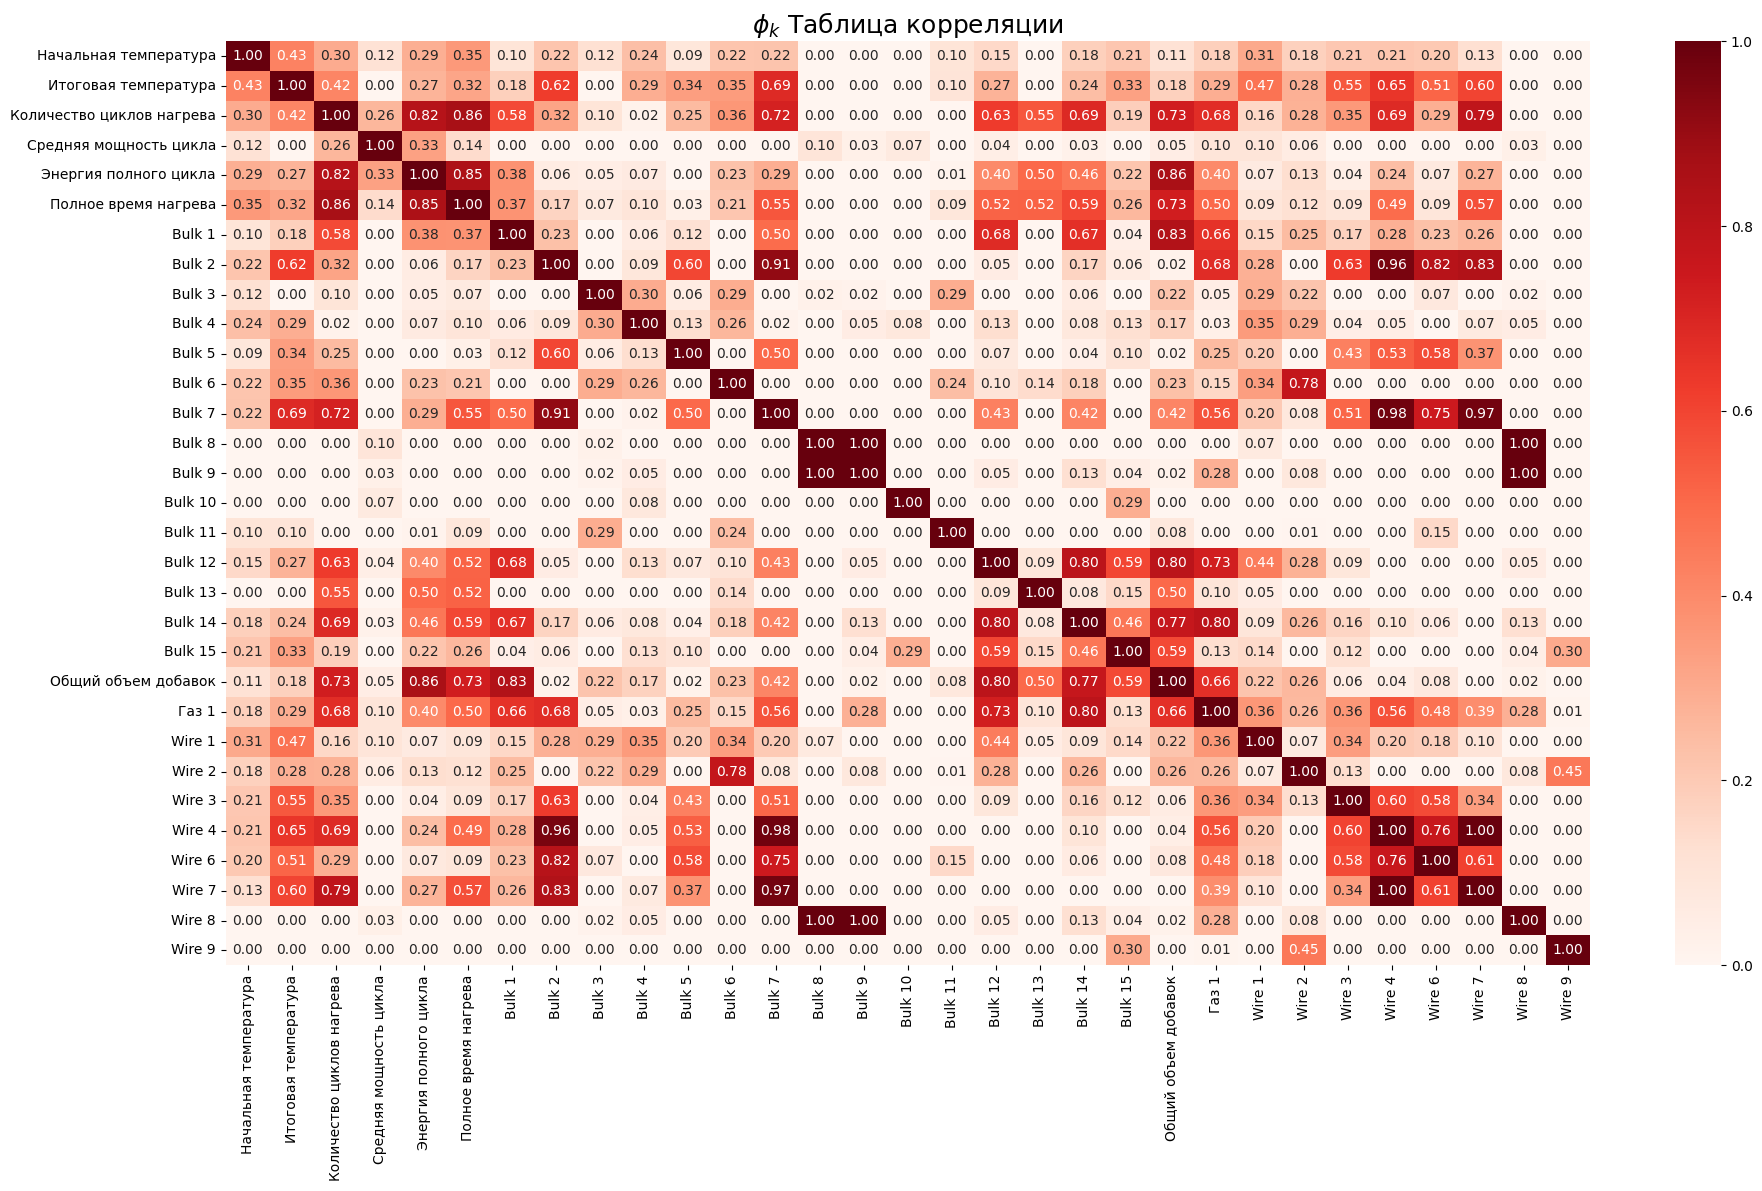

In [180]:
plt.figure(figsize=(22, 12))
sns.heatmap(df.phik_matrix(interval_cols=num_cols + [target]),
            cmap='Reds',
            annot=True,
            fmt='.2f')
plt.title(r'$\phi_k$ Таблица корреляции', fontsize=18);

In [181]:
df = df.drop(['Bulk 7','Bulk 8', 'Wire 8', 'Wire 5', 'Wire 4'], axis=1)

In [182]:
target = 'Итоговая температура'

num_cols = [ 
    'Начальная температура',
    'Средняя мощность цикла', 
    'Энергия полного цикла',
    'Полное время нагрева', 
    'Bulk 1', 
    'Bulk 2', 
    'Bulk 3',
    'Bulk 4',
    'Bulk 5', 
    'Bulk 6',   
    'Bulk 9', 
    'Bulk 10', 
    'Bulk 11',
    'Bulk 12', 
    'Bulk 13', 
    'Bulk 14', 
    'Bulk 15', 
    'Общий объем добавок',
    'Газ 1', 
    'Wire 1', 
    'Wire 2', 
    'Wire 3',  
    'Wire 6',
    'Wire 7', 
    'Wire 9', 

]

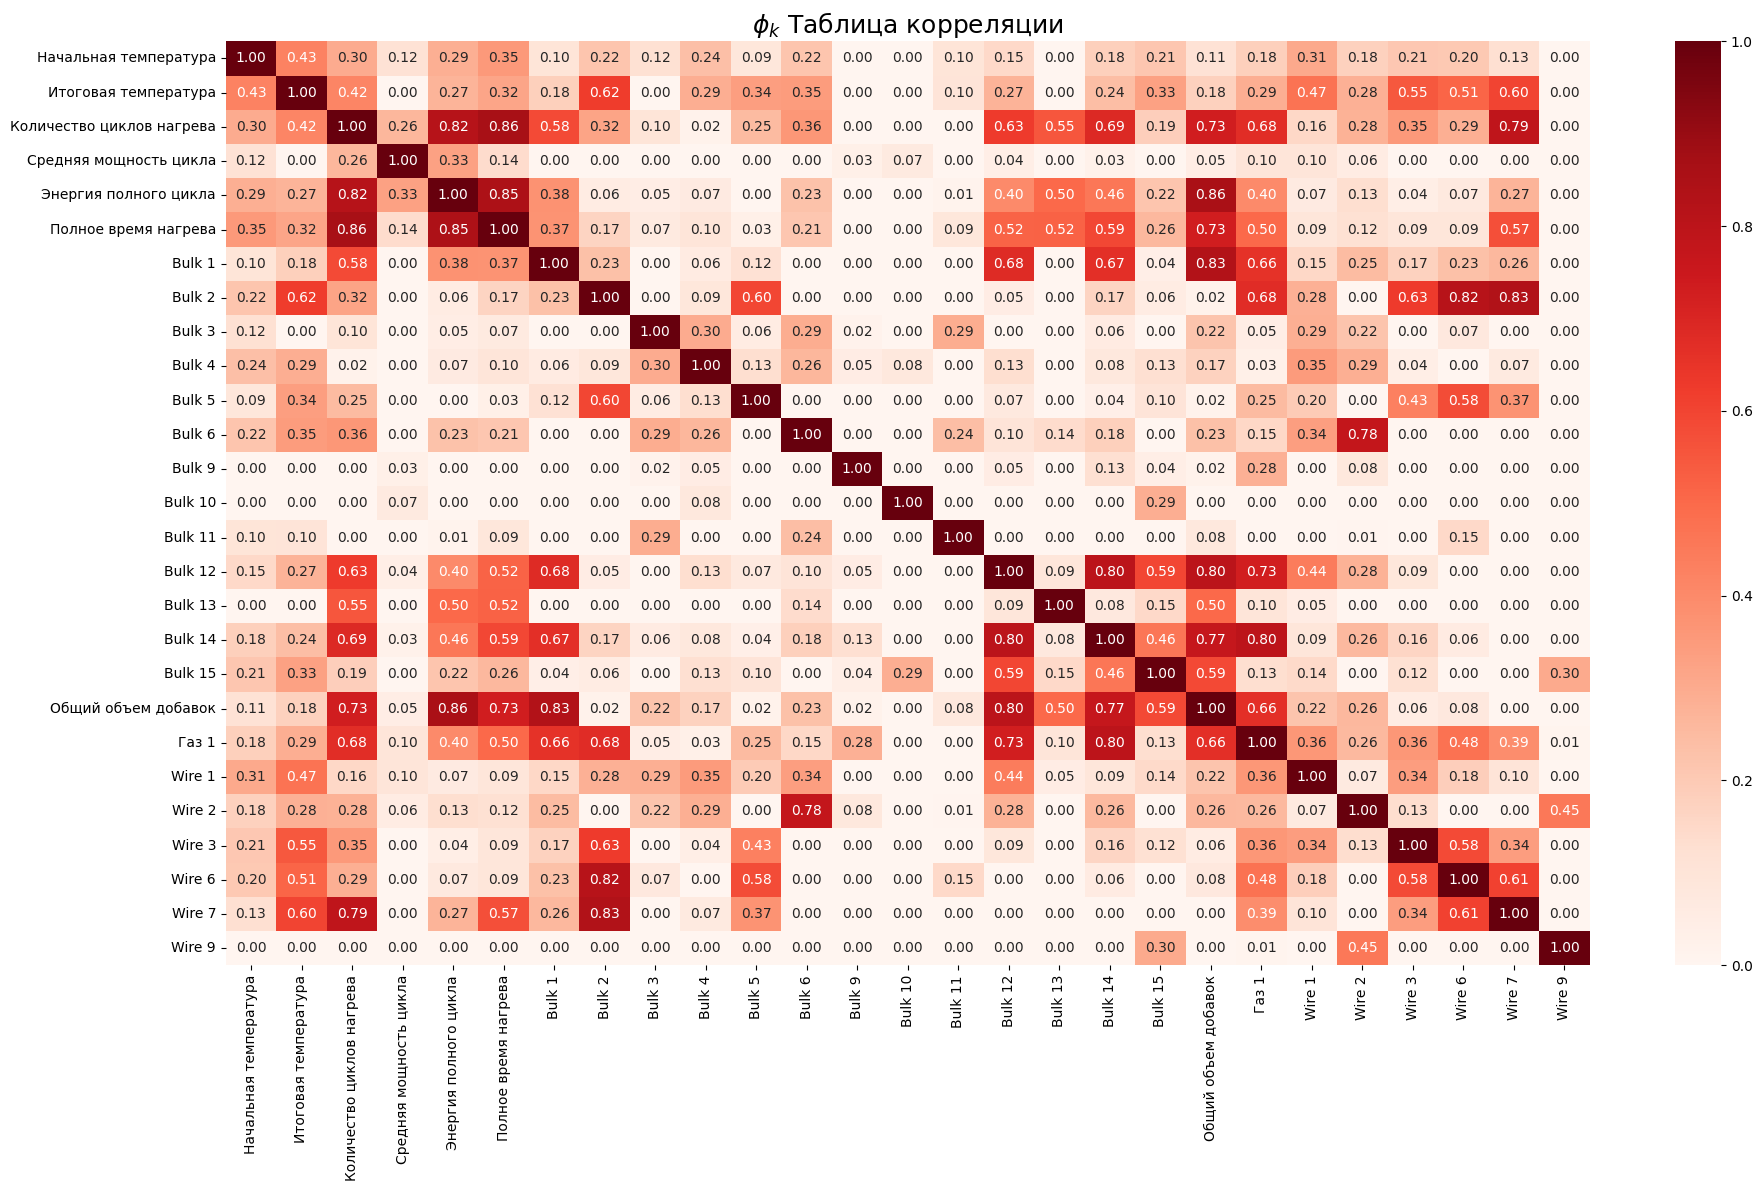

In [183]:
plt.figure(figsize=(22, 12))
sns.heatmap(df.phik_matrix(interval_cols=num_cols + [target]),
            cmap='Reds',
            annot=True,
            fmt='.2f')
plt.title(r'$\phi_k$ Таблица корреляции', fontsize=18);

Видим, что "Общий объем добавок" и "Bulk 12" стоит удалить: 

In [185]:
df = df.drop(['Общий объем добавок','Bulk 12'], axis=1)

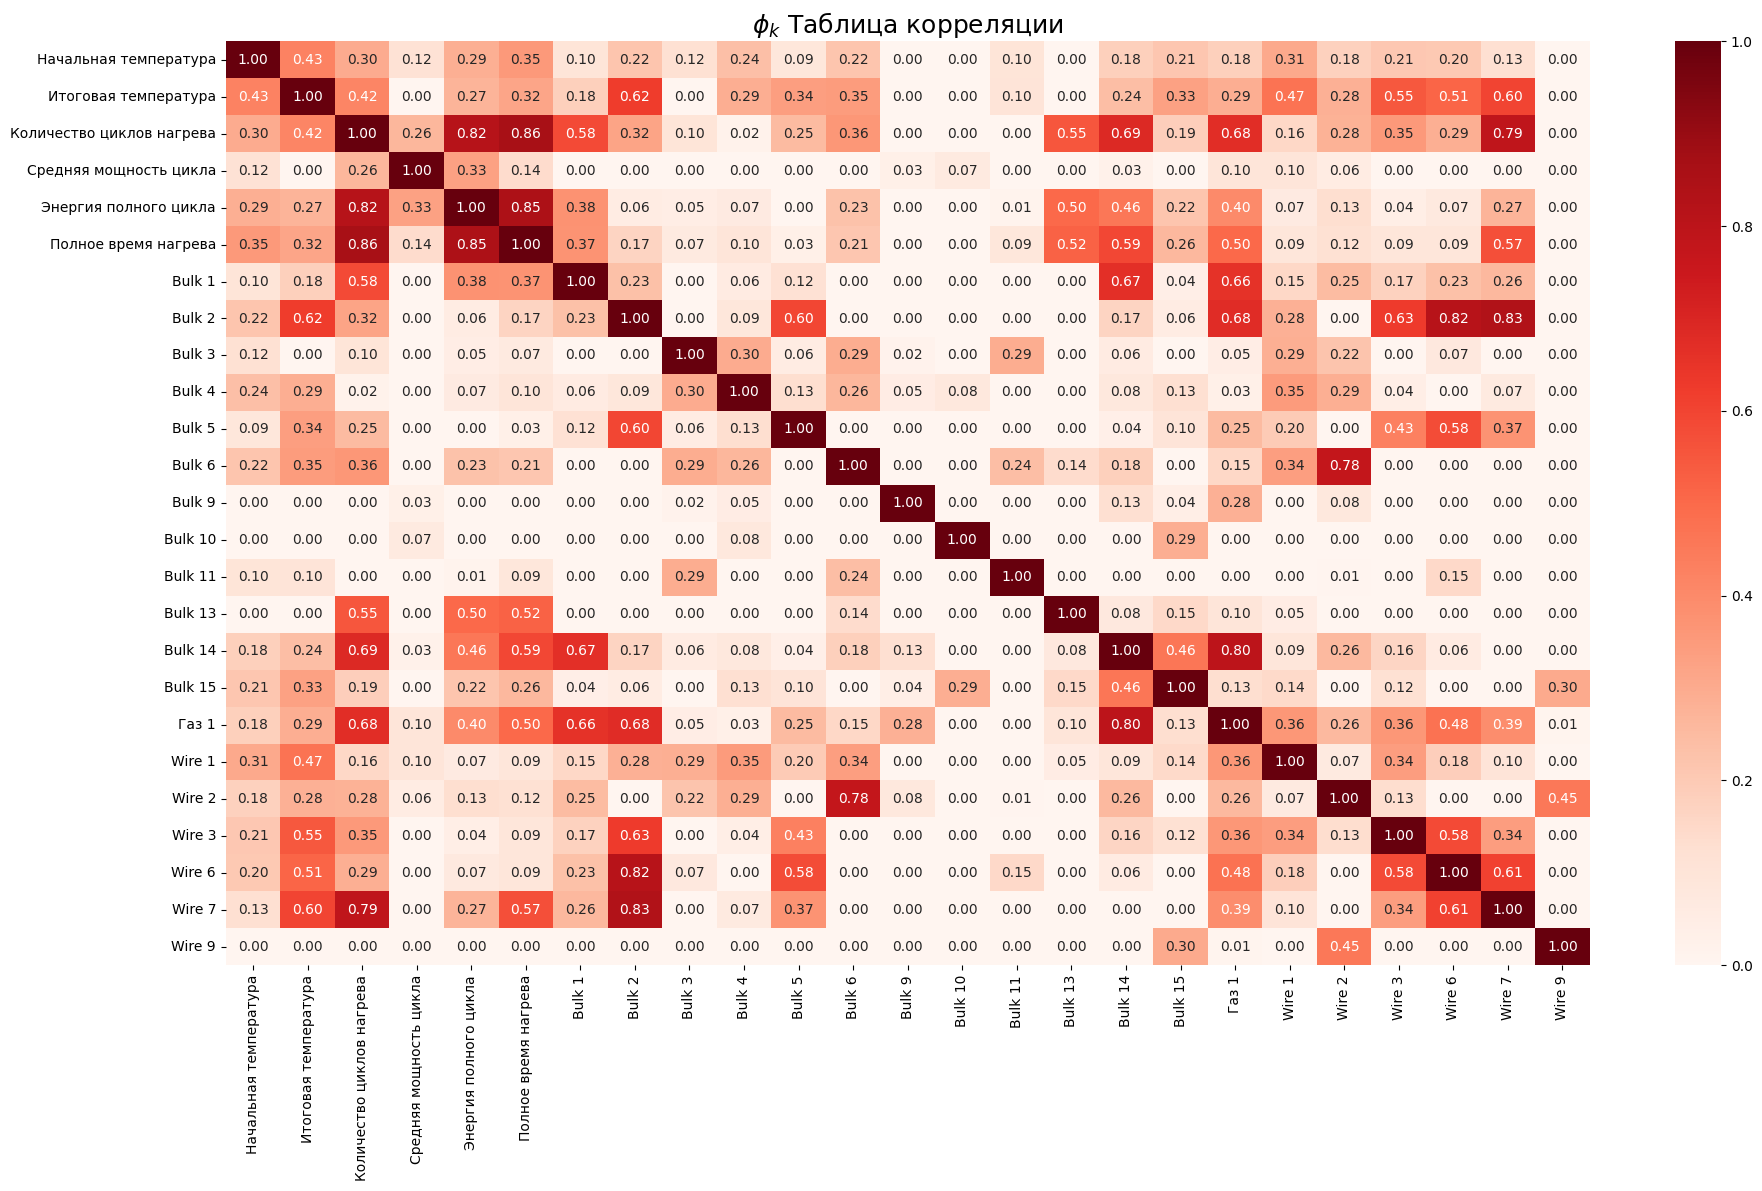

In [186]:
plt.figure(figsize=(22, 12))
sns.heatmap(df.phik_matrix(interval_cols=num_cols + [target]),
            cmap='Reds',
            annot=True,
            fmt='.2f')
plt.title(r'$\phi_k$ Таблица корреляции', fontsize=18);

**Вывод:**

Убедились, что данные объединились корректно. 

Корреляционный анализ показал, что некоторые признаки, а именно: 'Bulk 7','Bulk 8', 'Wire 8', 'Wire 5', 'Wire 4','Общий объем добавок'и 'Bulk 12' имеют чрезмерно высокую мультиколлинеарность, поэтому их стоит убрать из датафрейма.

## <a id='toc5_'></a> 5. Построение и обучение моделей[&#8593;](#toc0_)

### <a id='toc5_1_'></a> 5.1. Подготовка данных [&#8593;](#toc0_)

In [187]:
df.columns


Index(['Начальная температура', 'Итоговая температура',
       'Количество циклов нагрева', 'Средняя мощность цикла',
       'Энергия полного цикла', 'Полное время нагрева', 'Bulk 1', 'Bulk 2',
       'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 9', 'Bulk 10', 'Bulk 11',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'Газ 1', 'Wire 1', 'Wire 2', 'Wire 3',
       'Wire 6', 'Wire 7', 'Wire 9'],
      dtype='object')

In [188]:
df.head()

,Начальная температура,Итоговая температура,Количество циклов нагрева,Средняя мощность цикла,Энергия полного цикла,Полное время нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 6,Wire 7,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,1571,1613,5,0.74,770.28,1098,0,0,0,43,...,0,150,154,29.75,60.06,0.00,0.00,0.00,0.00,0.00
2,1581,1602,4,0.65,481.76,811,0,0,0,73,...,0,149,154,12.56,96.05,0.00,0.00,0.00,0.00,0.00
3,1596,1599,5,1.00,722.84,655,0,0,0,34,...,0,152,153,28.55,91.16,0.00,0.00,0.00,0.00,0.00
4,1601,1625,4,0.85,683.46,741,0,0,0,81,...,0,153,154,18.84,89.06,0.00,0.00,0.00,0.00,0.00
5,1576,1602,4,0.70,512.17,869,0,0,0,78,...,0,151,152,5.41,89.24,9.11,0.00,0.00,0.00,0.00


In [197]:
target = 'Итоговая температура'

num_cols = [ 
    'Начальная температура',
    'Средняя мощность цикла',
    'Полное время нагрева',
    'Энергия полного цикла',
    'Bulk 1', 
    'Bulk 2', 
    'Bulk 3',
    'Bulk 4',
    'Bulk 5', 
    'Bulk 6',   
    'Bulk 9', 
    'Bulk 10', 
    'Bulk 11',
    'Bulk 13', 
    'Bulk 14', 
    'Bulk 15', 
    'Газ 1', 
    'Wire 1', 
    'Wire 2', 
    'Wire 3',  
    'Wire 6',
    'Wire 7', 
    'Wire 9', 
]

In [198]:
X = df.drop(columns=[target])
y = df[target]

X.shape, y.shape

((2324, 24), (2324,))

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
display((X_train.shape, y_train.shape))
display((X_test.shape, y_test.shape))

((1743, 24), (1743,))

((581, 24), (581,))

### <a id='toc5_2_'></a> 5.2. Построение пайплайна для моделей [&#8593;](#toc0_)

In [200]:
data_preprocessor = ColumnTransformer(
    [
     ('num', StandardScaler(), num_cols)
    ], 
    force_int_remainder_cols=False,
    remainder='passthrough'
)

In [201]:
final_pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [202]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
    },
    
    # словарь для модели KNeighborsRegressor() 
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2, 6),
        'preprocessor__num': [StandardScaler(),MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression(n_jobs=-1)],
        'preprocessor__num': [StandardScaler(),MinMaxScaler(),'passthrough']
    },
    
     # словарь для модели SVR()
    {
        'models': [SVR()],
        'models__C': [0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(),MinMaxScaler(),'passthrough']
    },
    
    # словарь для модели RandomForestRegressor()
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)],
        'models__n_estimators': [10, 50, 100],
        'models__max_depth': [20, 25, 30],
        'models__min_samples_split': range(2, 6),
        'models__min_samples_leaf': range(2, 6),
    },
    # словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1)],
        'models__learning_rate': [0.03, 0.04, 0.05, 0.06, 0.07],
        'models__num_leaves': [10, 50, 100],
        'models__max_depth': [15, 16, 17]
    },
]

In [203]:
grid= GridSearchCV(
    final_pipe,
    param_grid=param_grid,
    scoring= 'neg_mean_absolute_error',
    cv=5,
    verbose=1,
)

In [204]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 232 candidates, totalling 1160 fits


C:\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.w

CPU times: total: 15min 29s
Wall time: 4min 32s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Начальная '
                                                                          'температура',
                                                                          'Средняя '
                                                                          'мощность '
                                                                          'цикла',
                                                                          'Полное '
                                                                          'время '
                                                                          'нагрева',
                                                                          'Энергия '
                                                                          'полного '
                                                                          'цикла',
                                                                          'Bulk '
                                                                          '1',
                                                                          'Bulk '
                                                                          '2',
                                                                          'Bulk '
                                                                          '3',
                                                                          'Bulk '
                                                                          '4',
                                                                          'Bulk '
                                                                          '5',
                                                                          'Bulk '
                                                                          '6',
                                                                          'Bulk '
                                                                          '9',
                                                                          'Bulk...
                          'models__max_depth': [20, 25, 30],
                          'models__min_samples_leaf': range(2, 6),
                          'models__min_samples_split': range(2, 6),
                          'models__n_estimators': [10, 50, 100]},
                         {'models': [LGBMRegressor(n_jobs=-1,
                                                   random_state=250225,
                                                   verbosity=-1)],
                          'models__learning_rate': [0.03, 0.04, 0.05, 0.06,
                                                    0.07],
                          'models__max_depth': [15, 16, 17],
                          'models__num_leaves': [10, 50, 100]}],
             scoring='neg_mean_absolute_error', verbose=1)

### <a id='toc5_3_'></a> 5.3. Выбор лучшей модели  [&#8593;](#toc0_)

In [207]:
abs(grid.best_score_)

6.127408070746057

In [208]:
pd.DataFrame(grid.cv_results_)[['rank_test_score', 'param_models', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(5)

,rank_test_score,param_models,mean_test_score,params
37,1,SVR(),-6.13,"{'models': SVR(), 'models__C': 10, 'preprocessor__num': StandardScaler()}"
41,2,SVR(),-6.24,"{'models': SVR(), 'models__C': 100, 'preprocessor__num': MinMaxScaler()}"
29,3,LinearRegression(n_jobs=-1),-6.27,"{'models': LinearRegression(n_jobs=-1), 'preprocessor__num': MinMaxScaler()}"
28,4,LinearRegression(n_jobs=-1),-6.27,"{'models': LinearRegression(n_jobs=-1), 'preprocessor__num': StandardScaler()}"
30,5,LinearRegression(n_jobs=-1),-6.27,"{'models': LinearRegression(n_jobs=-1), 'preprocessor__num': 'passthrough'}"


Лучшая модель SVR показывает результат МАЕ=6,13

Посмотрим на результаты на тестовой выборке:

In [209]:
y_pred = grid.predict(X_test)
round(mean_absolute_error(y_test, y_pred),2)

6.09

Отличный результат метрика MAE = 6,09 < 6,8

Проверим модель на адекватность с помощью DummyRegressor:

In [210]:
final_pipe_dummy1 = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models',DummyRegressor())
    ]
)

final_pipe_dummy1.fit(X_train, y_train)
dummy_model_probas1 = final_pipe_dummy1.predict(X_test)
mean_absolute_error(y_test, dummy_model_probas1)


8.040034245662278

Модель адекватна

### <a id='toc5_4_'></a> 5.4. Анализ остатков  [&#8593;](#toc0_)

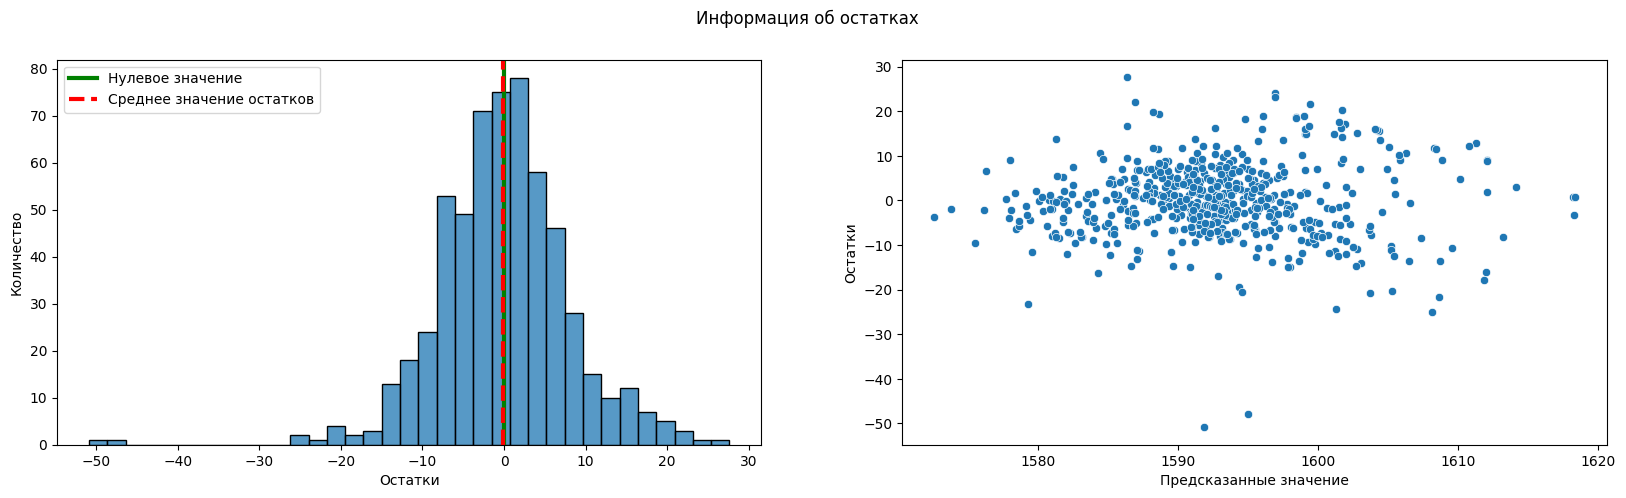

In [215]:
get_plots_about_residuals(y_test, y_pred)

**Вывод**:

- Были задействованы 6 моделей в пайплайне с полным перебором параметров, в ходе которой выбрана лучшая - *SVR*(метод опорных векторов) с *StandardScaler* и гиперпараметром (коэффициентом для определения допустимых ошибок в присвоении значения) С = 10. Скорее всего это обусловлено численными значениями признаков, зависимости между которыми алгоритм опорных векторов ищет даже лучше бустинга.
- Метрика МАЕ = 6,09 на тестовых данных, что удовлетворяет критерию успеха (<=6,8).
- Разброс остатков является нормальным и без смещений, дисперсия приближена к равномерной.



## <a id='toc6_'></a> 6. Анализ важности признаков [&#8593;](#toc0_)

In [211]:
the_best_model = grid.best_estimator_.named_steps['models']
the_best_model

SVR(C=10)

In [212]:
X_train_transform = grid.best_estimator_.named_steps['preprocessor'].transform(X_train)

In [213]:
feature_names_ = grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

PermutationExplainer explainer: 1744it [2:41:49,  5.57s/it]                                                            


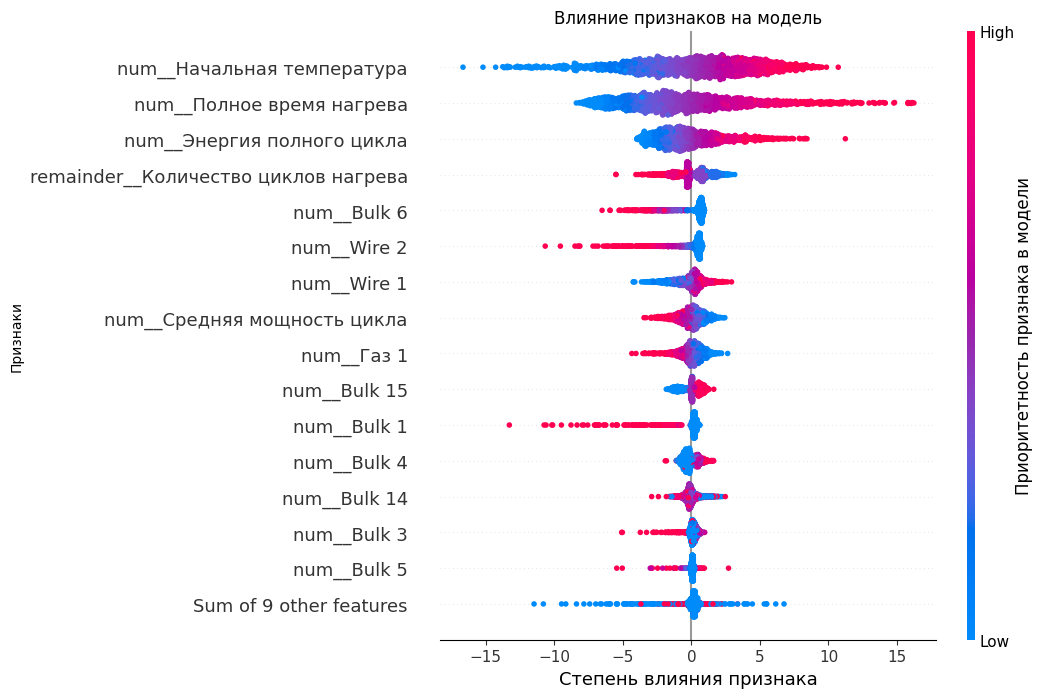

In [214]:
#explainer = shap.Explainer(the_best_model.predict, X_train_transform, feature_names=feature_names_)

#shap_values = explainer(X_train_transform)

#shap.plots.beeswarm(shap_values, max_display=16,color_bar_label='Приоритетность признака в модели', show=False)
#plt.title('Влияние признаков на модель')
#plt.xlabel('Степень влияния признака')
#plt.ylabel('Признаки')
#plt.show()

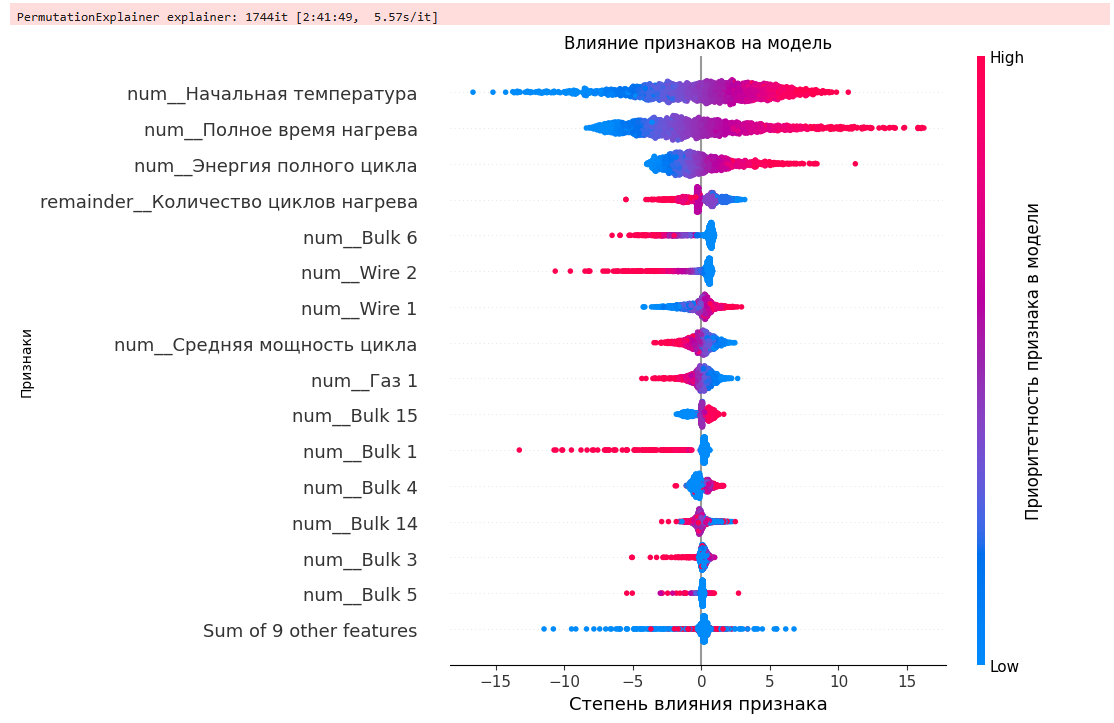

**Вывод:**

"Начальная температура", "полное время нагрева" и "энергия полного цикла" являются наиболее важными признаками для используемой модели. Стоит отметить, что количество циклов нагрева и некоторые другие признаки обладают противоположным влиянием по модулю.

## <a id='toc7_'></a> 7. Общий вывод [&#8593;](#toc0_)

В ходе данного проекта мы исследовали данные предприятия "Стальная птица" для построения модели МО с целью предсказания итоговой температуры обрабатываемого сплава, для чего были проделаны следующие этапы:

- Загрузили данные, провели их первичный осмотр.
- Провели исследовательский анализ данных и предобработку отдельных датафреймов: оценили необходимость признаков для обучения моделей, добавили новые признаки, избавились от пропусков и явных выбросов.
- Объединенили признаки в один датафрейм.
- Провели исследовательский и корреляционный анализ данных объединенного датафрейма. Были удалены некоторые признаки, имеющие высокую корреляцию с остальными признаками, а также имеющие высокий коэффициент VIF признаки.
- Подготовили данные, собрали пайплайн из 6 алгоритмов с перебором гиперпараметров с помощью GridSearchCV и обучили модели.
- Выбрали лучшую модель: SVR(метод опорных векторов) с StandardScaler и гиперпараметром (коэффициентом для определения допустимых ошибок в присвоении значения) С = 10 и проверили ее качество на тестовых данных: метрика МАЕ=6,09, что меньше заявленной заказчиком.
- Также мы оценили разброс остатков (распределение остатков нормальное) и важность признаков в модели: "Начальная температура", "полное время нагрева" и "энергия полного цикла" являются наиболее важными для модели.

Ориентируясь на важность признаков, можно отметить, что предприятию стоит учитывать полную энергию на весь цикл нагрева и уменьшать количество циклов нагрева(возможно сократить количество промежуточных замеров температуры). Так же вляют объемы первых двух проволочных материалов и сыпущей добавки 6: чтобы нагреть общий сплав при большом количестве добавок требуется больше времени и энергии, логично. Средняя точность модели в 6 градусов может помочь производству правильно распределять ресурсы, но предсказывать температуру для создания уникальных сплавов пока не пригодна, необходимо больше данных.